In [1]:
import pickle
import pandas as pd
import pandas_profiling
from gc import collect
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.preprocessing import normalize
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import hdbscan
from graphviz import Source
from IPython.display import SVG
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import RFE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

In [62]:
df = pd.read_excel('bases_hk1_hk2.xlsx')

In [63]:
num_questions = 30
for i in range(num_questions):
    df['pregunta_{}'.format(i + 1)] = np.random.random(df.shape[0])
df.head()

,cod_ide,Cargo,Y,nEntidades_competencia,nDesem_ult_semana,cero_cuotas,nPorcentaje_cero_cuotas_ope,nPorcentaje_sal_cero_cuo,Amonestacion,nAmonestacion_suspension,...,pregunta_21,pregunta_22,pregunta_23,pregunta_24,pregunta_25,pregunta_26,pregunta_27,pregunta_28,pregunta_29,pregunta_30
0,C00000001,ASESOR COMERCIAL FUNCIONARIO,1,1,0.256354,si,0.000000,0.000000,no,no,...,0.155440,0.933387,0.352760,0.554334,0.240581,0.708708,0.207997,0.524795,0.996661,0.856284
1,C00000002,ASESOR COMERCIAL MASTER,1,0,0.406922,si,0.001969,0.000141,no,no,...,0.779381,0.929419,0.069090,0.296235,0.781798,0.283405,0.106355,0.649087,0.870444,0.953864
2,C00000003,ASESOR COMERCIAL MASTER,0,5,0.321911,si,0.000000,0.000000,no,no,...,0.444518,0.663385,0.102527,0.867034,0.356141,0.806737,0.272191,0.889485,0.591903,0.614530
3,C00000004,ASESOR COMERCIAL FUNCIONARIO,0,3,0.294114,si,0.008791,0.015452,no,no,...,0.929461,0.992835,0.045157,0.249147,0.462822,0.554595,0.999452,0.474711,0.350049,0.982207
4,C00000005,ASESOR COMERCIAL FUNCIONARIO,1,2,0.315331,no,0.000000,0.000000,no,no,...,0.386267,0.595219,0.905148,0.003362,0.823834,0.684174,0.459148,0.822055,0.098748,0.121376


In [65]:
df.to_csv('bases_full.csv', index=False)

In [4]:
df = df.drop('Y', axis=1)

In [5]:
pandas_profiling.ProfileReport(df)

Number of variables,25
Number of observations,768
Total Missing (%),0.0%
Total size in memory,150.1 KiB
Average record size in memory,200.1 B
Numeric,11
Categorical,13
Date,0
Text (Unique),1
Rejected,0
Distinct count,2


In [6]:
# Agregar mas graficos de categoricos

In [7]:
dtypes = ['category', 'bool', 'object']
df_categorical = df.loc[:, [col for col in df.columns]].select_dtypes(include=dtypes)
df_categorical.head()
df_categorical.shape
list(df_categorical)

,cod_ide,Cargo,cero_cuotas,Amonestacion,nAmonestacion_suspension,herencia,nProbMoraNoHeredada,nProbMoraHeredada,Clasificacion_Asesor_Urb_Rur,Genero,EstadoCivil,Estado_Civil_Sexo,nProductividad_dic,ingresoef
0,C00000001,ASESOR COMERCIAL FUNCIONARIO,si,no,no,si,bueno,malo,U,Masculino,Soltero,M_Soltero,bueno,NO
1,C00000002,ASESOR COMERCIAL MASTER,si,no,no,si,malo,malo,U,Femenino,Otros,otros,bueno,NO
2,C00000003,ASESOR COMERCIAL MASTER,si,no,no,si,malo,bueno,U,Femenino,Casado,Casado,bueno,NO
3,C00000004,ASESOR COMERCIAL FUNCIONARIO,si,no,no,si,bueno,malo,U,Femenino,Soltero,F_Soltero,bueno,NO
4,C00000005,ASESOR COMERCIAL FUNCIONARIO,no,no,no,si,malo,bueno,U,Femenino,Soltero,F_Soltero,bueno,NO


(768, 14)

['cod_ide',
 'Cargo',
 'cero_cuotas',
 'Amonestacion',
 'nAmonestacion_suspension',
 'herencia',
 'nProbMoraNoHeredada',
 'nProbMoraHeredada',
 'Clasificacion_Asesor_Urb_Rur',
 'Genero',
 'EstadoCivil',
 'Estado_Civil_Sexo',
 'nProductividad_dic',
 'ingresoef']

In [8]:
df = pd.get_dummies(df, columns=['Cargo', 'Genero', 'EstadoCivil', 'Clasificacion_Asesor_Urb_Rur'], prefix='D_')

for feature in ['nProbMoraNoHeredada', 'nProbMoraHeredada', 'nProductividad_dic']:
    df.loc[:, feature] = df.loc[:, feature].map({ 'bueno': 1, 'malo': 0 })
    
for feature in ['cero_cuotas', 'Amonestacion', 'nAmonestacion_suspension', 'herencia']:
    df.loc[:, feature] = df.loc[:, feature].map({ 'si': 1, 'no': 0 })
    
df.loc[:, 'ingresoef'] = df.loc[:, 'ingresoef'].map({ 'SI': 1, 'NO': 0 })

df_categorical = df.loc[:, [col for col in list(df) if col in list(df_categorical) or col.startswith('D_')]]

for feature in list(df_categorical):
    if feature != 'cod_ide':
        df[feature].value_counts()

1    514
0    254
Name: cero_cuotas, dtype: int64

0    721
1     47
Name: Amonestacion, dtype: int64

0    574
1    194
Name: nAmonestacion_suspension, dtype: int64

1    723
0     45
Name: herencia, dtype: int64

0    417
1    351
Name: nProbMoraNoHeredada, dtype: int64

1    402
0    366
Name: nProbMoraHeredada, dtype: int64

M_Soltero    350
F_Soltero    179
Casado       147
otros         92
Name: Estado_Civil_Sexo, dtype: int64

1    731
0     37
Name: nProductividad_dic, dtype: int64

0    584
1    184
Name: ingresoef, dtype: int64

0    707
1     61
Name: D__ASESOR COMERCIAL FUNCIONARIO, dtype: int64

0    611
1    157
Name: D__ASESOR COMERCIAL JUNIOR 1, dtype: int64

0    528
1    240
Name: D__ASESOR COMERCIAL JUNIOR 2, dtype: int64

0    637
1    131
Name: D__ASESOR COMERCIAL MASTER, dtype: int64

0    589
1    179
Name: D__ASESOR COMERCIAL SENIOR, dtype: int64

0    530
1    238
Name: D__Femenino, dtype: int64

1    530
0    238
Name: D__Masculino, dtype: int64

0    621
1    147
Name: D__Casado, dtype: int64

0    676
1     92
Name: D__Otros, dtype: int64

1    529
0    239
Name: D__Soltero, dtype: int64

0    607
1    161
Name: D__R, dtype: int64

1    607
0    161
Name: D__U, dtype: int64

In [9]:
dtypes = ['number']
df_numeric = df.loc[:, [col for col in df.columns if col not in df_categorical.columns]].select_dtypes(include=dtypes)
df_numeric.head()
df_numeric.shape
list(df_numeric)

,nEntidades_competencia,nDesem_ult_semana,nPorcentaje_cero_cuotas_ope,nPorcentaje_sal_cero_cuo,nvarsaldocapital,nporcentaje_Herencia,nOperaciones,nRatio_crec_deuda,Edad,nProductividad,antiguedad
0,1,0.256354,0.000000,0.000000,0.013561,0.380552,20,0.880677,36,0.823077,116
1,0,0.406922,0.001969,0.000141,0.042866,0.444054,24,2.061512,46,0.750000,16
2,5,0.321911,0.000000,0.000000,-0.005801,0.020612,22,0.668892,58,0.827303,140
3,3,0.294114,0.008791,0.015452,0.018111,0.300313,26,0.722767,34,1.100000,10
4,2,0.315331,0.000000,0.000000,0.004865,0.151475,26,0.000000,36,0.906250,119


(768, 11)

['nEntidades_competencia',
 'nDesem_ult_semana',
 'nPorcentaje_cero_cuotas_ope',
 'nPorcentaje_sal_cero_cuo',
 'nvarsaldocapital',
 'nporcentaje_Herencia',
 'nOperaciones',
 'nRatio_crec_deuda',
 'Edad',
 'nProductividad',
 'antiguedad']

In [10]:
df_discrete = df.loc[:, [col for col in df_numeric.columns if (df[col].dropna() - df[col].dropna().astype(int) == 0).all()]]
df_discrete.head()
df_discrete.shape
list(df_discrete)

,nEntidades_competencia,nOperaciones,Edad,antiguedad
0,1,20,36,116
1,0,24,46,16
2,5,22,58,140
3,3,26,34,10
4,2,26,36,119


(768, 4)

['nEntidades_competencia', 'nOperaciones', 'Edad', 'antiguedad']

In [11]:
df_continuous = df.loc[:, [col for col in df_numeric.columns if col not in df_discrete]]
df_continuous.head()
df_continuous.shape
list(df_continuous)

,nDesem_ult_semana,nPorcentaje_cero_cuotas_ope,nPorcentaje_sal_cero_cuo,nvarsaldocapital,nporcentaje_Herencia,nRatio_crec_deuda,nProductividad
0,0.256354,0.000000,0.000000,0.013561,0.380552,0.880677,0.823077
1,0.406922,0.001969,0.000141,0.042866,0.444054,2.061512,0.750000
2,0.321911,0.000000,0.000000,-0.005801,0.020612,0.668892,0.827303
3,0.294114,0.008791,0.015452,0.018111,0.300313,0.722767,1.100000
4,0.315331,0.000000,0.000000,0.004865,0.151475,0.000000,0.906250


(768, 7)

['nDesem_ult_semana',
 'nPorcentaje_cero_cuotas_ope',
 'nPorcentaje_sal_cero_cuo',
 'nvarsaldocapital',
 'nporcentaje_Herencia',
 'nRatio_crec_deuda',
 'nProductividad']

## Corr

In [12]:
def make_correlation_graphic(df):
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 15))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

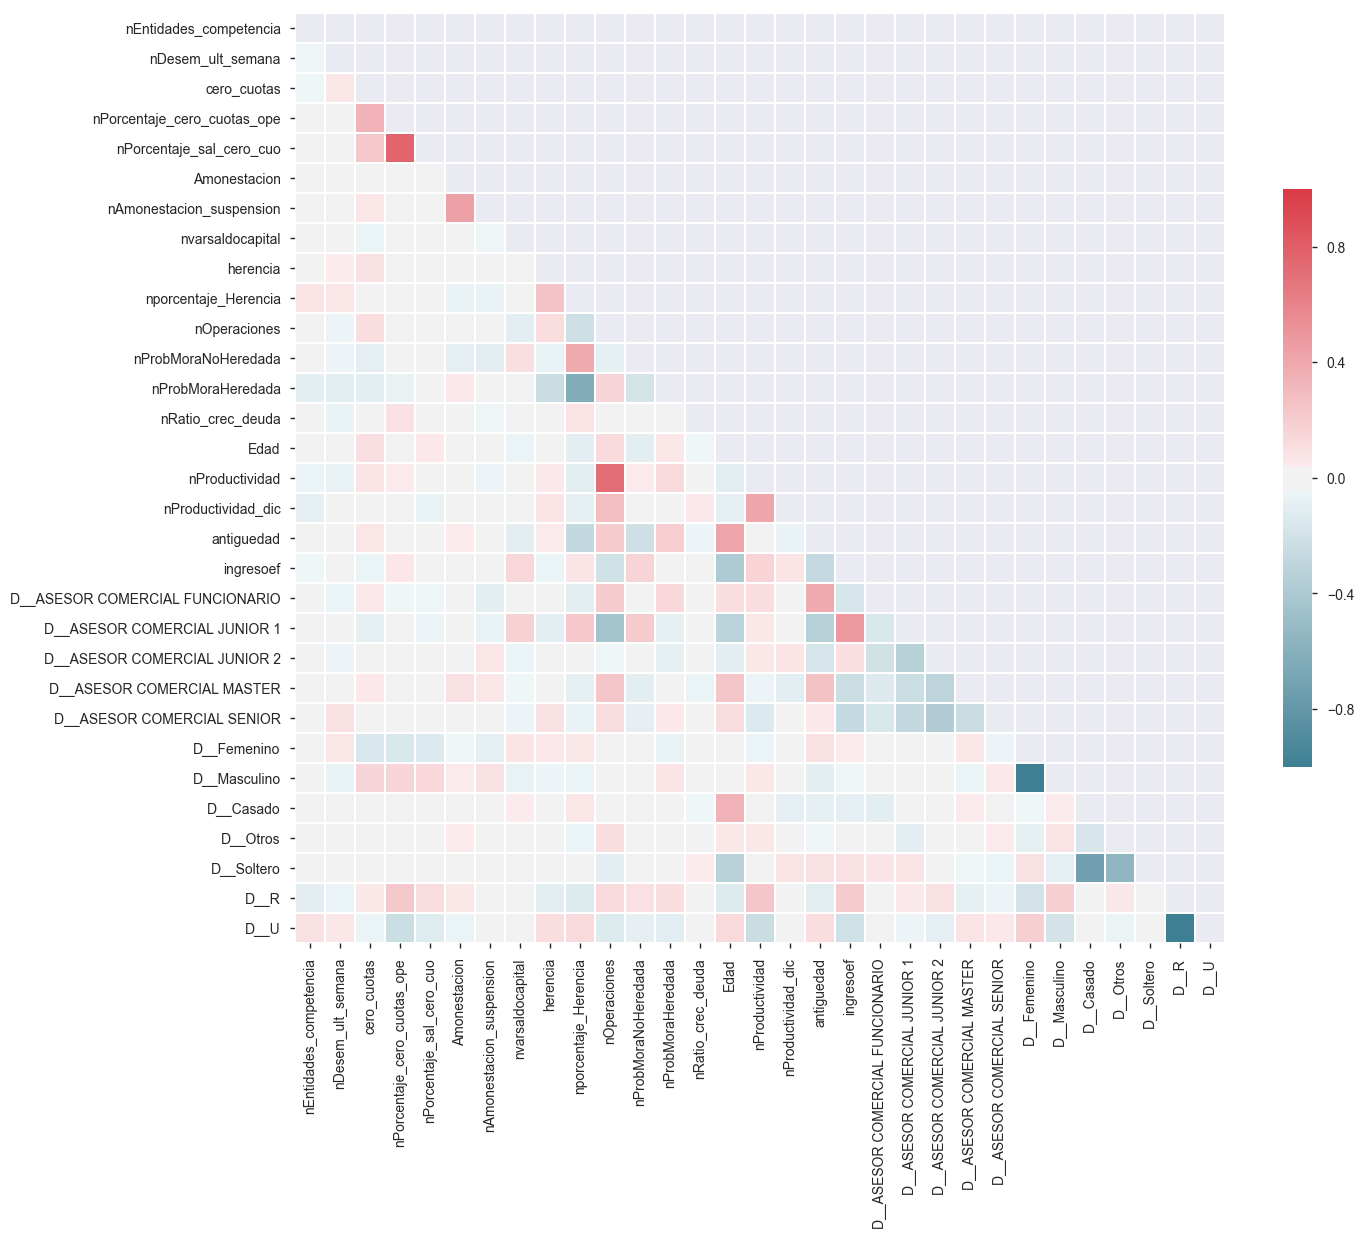

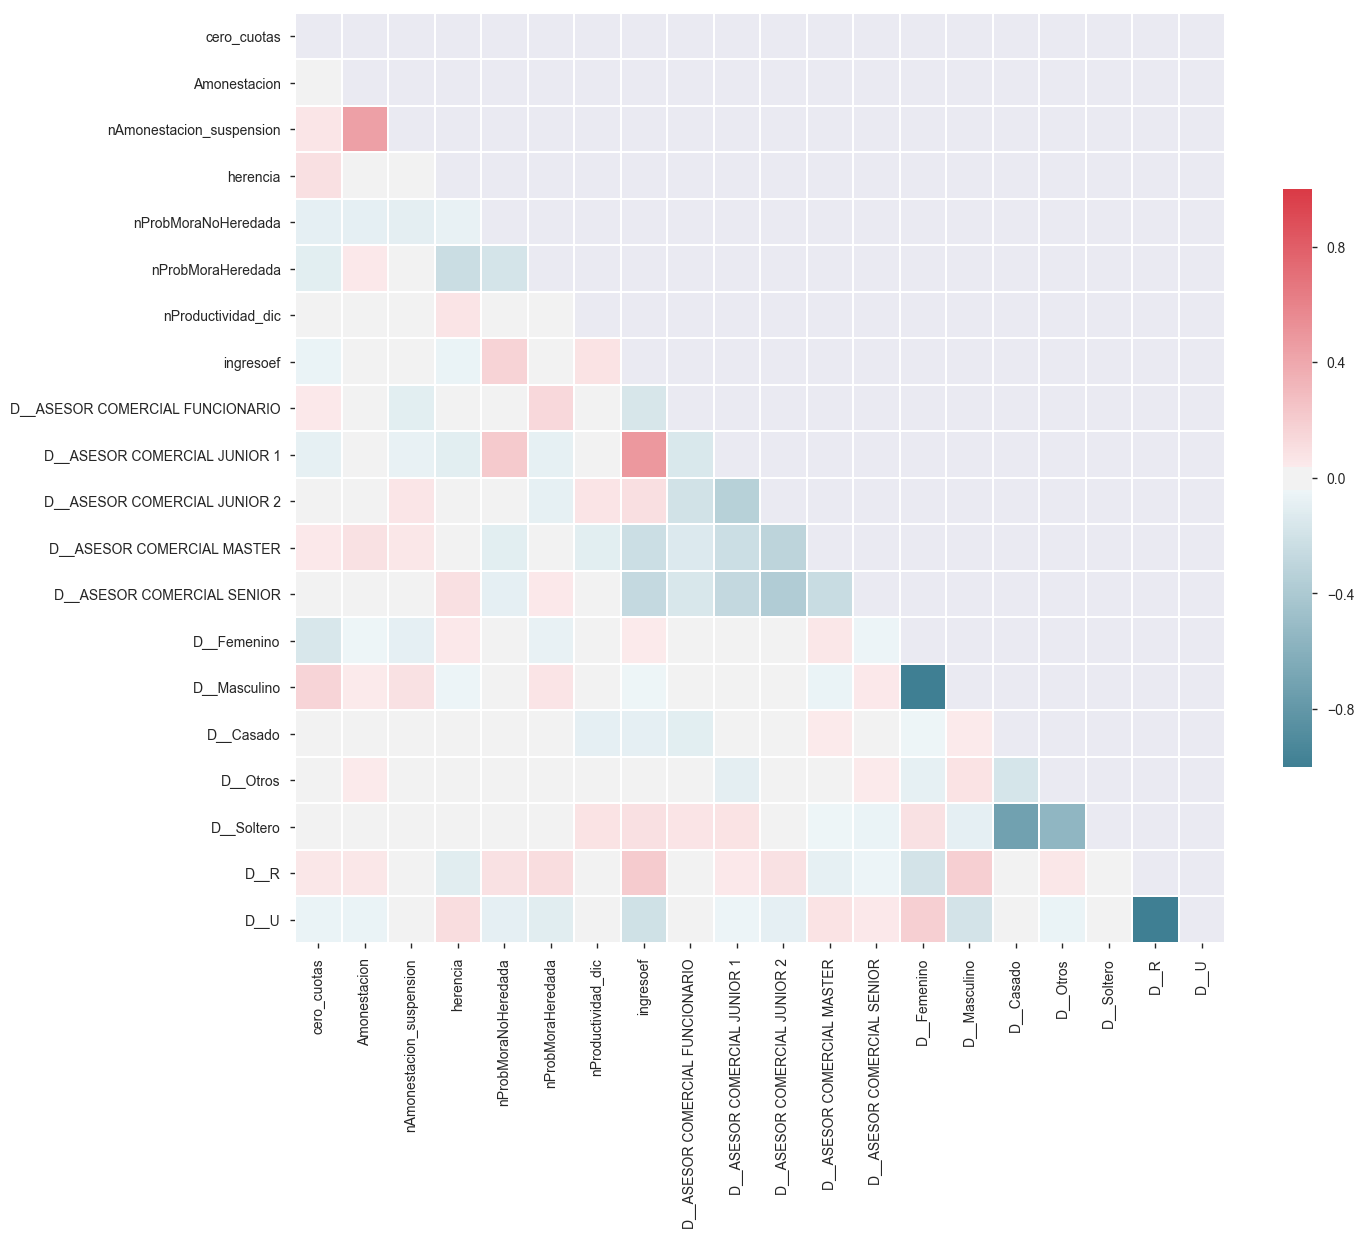

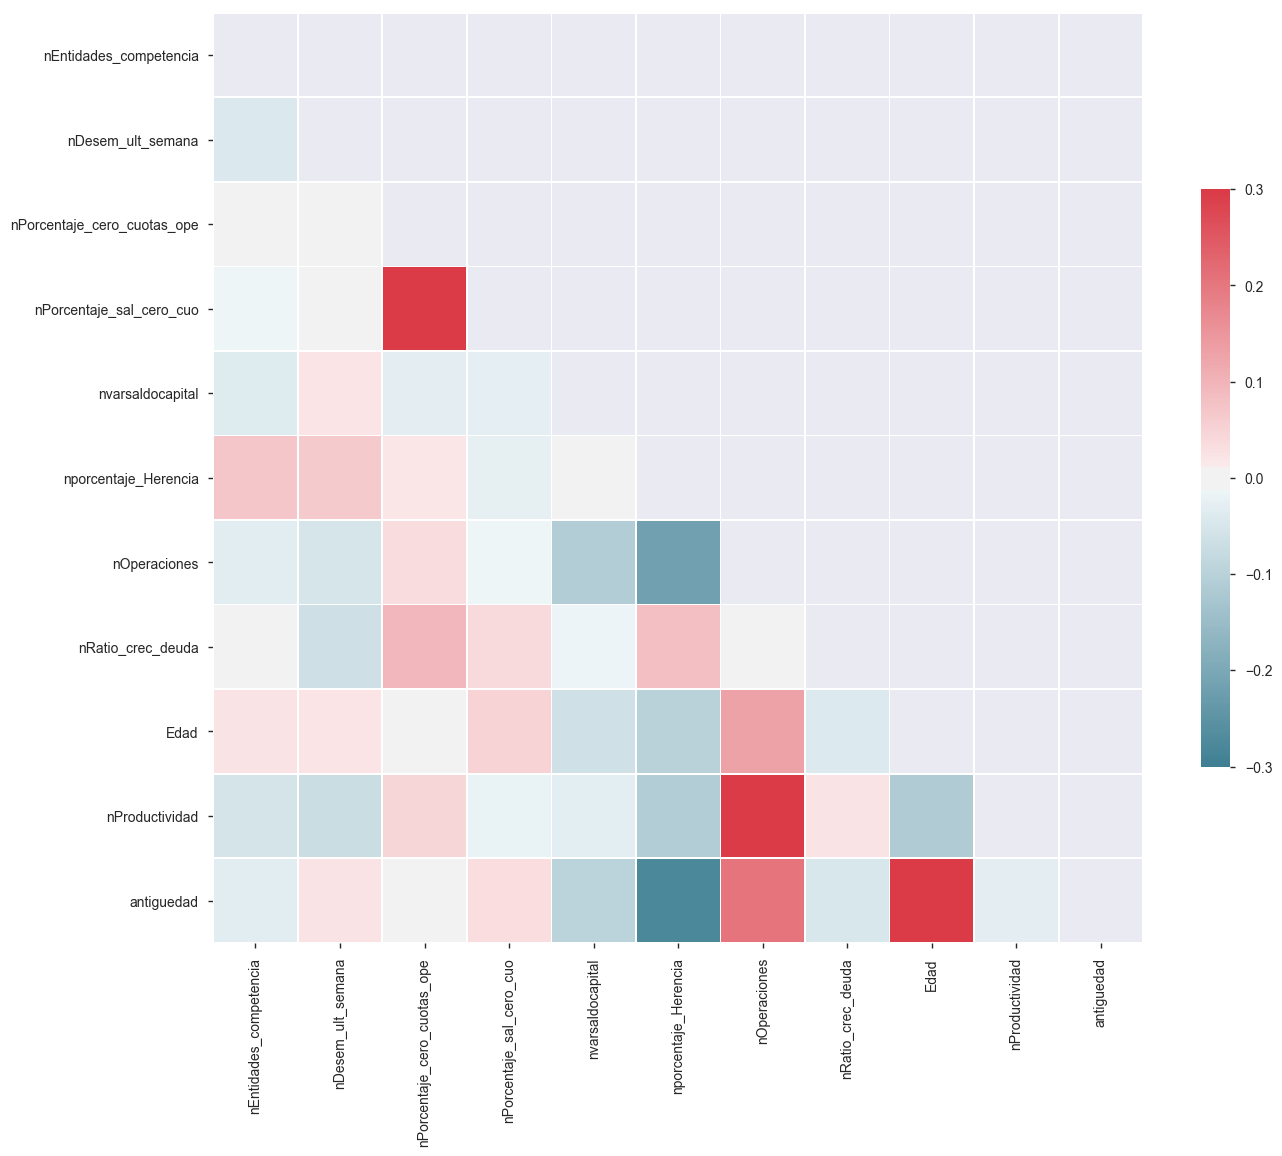

In [13]:
make_correlation_graphic(df)
make_correlation_graphic(df_categorical)
make_correlation_graphic(df_numeric)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


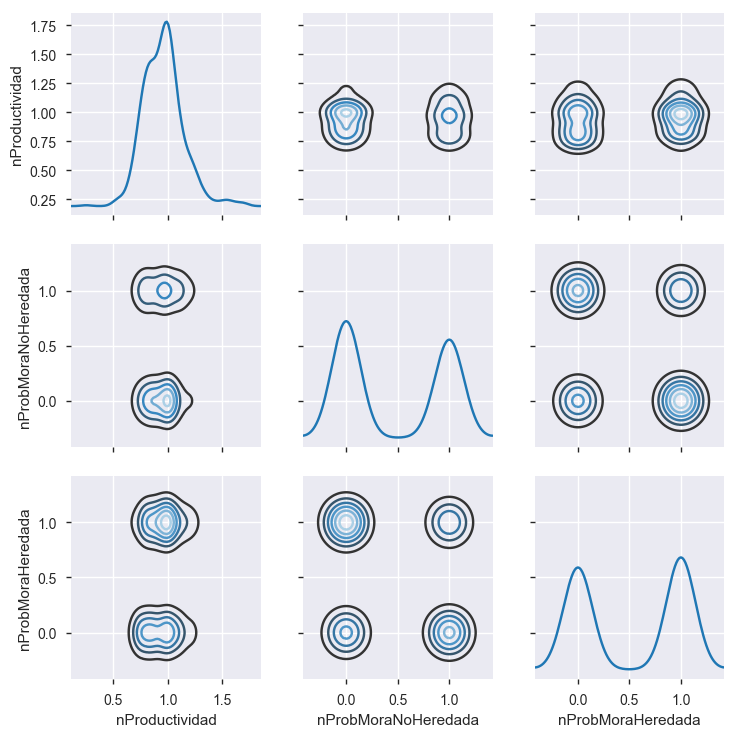

In [14]:
g = sns.PairGrid(df[['nProductividad', 'nProbMoraNoHeredada', 'nProbMoraHeredada']])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6)

In [15]:
df['PM'] = df['nProbMoraHeredada'] + df['nProbMoraNoHeredada']

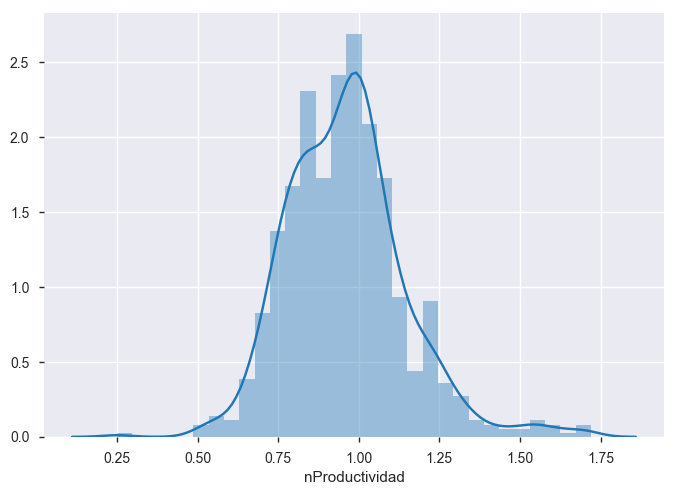

In [16]:
sns.distplot(df['nProductividad'])

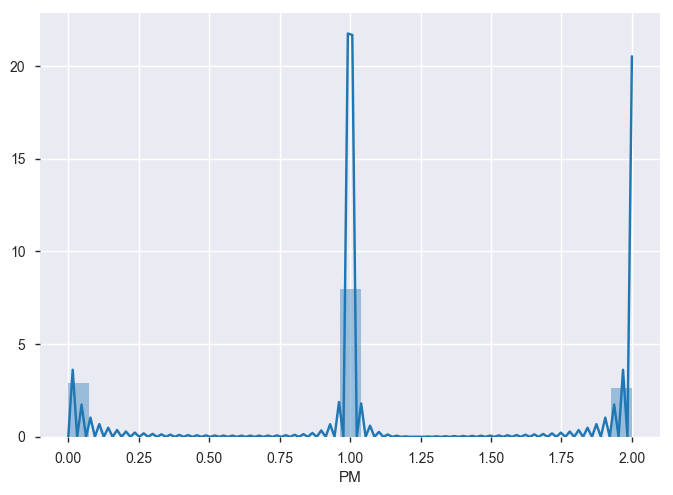

In [17]:
sns.distplot(df['PM'])

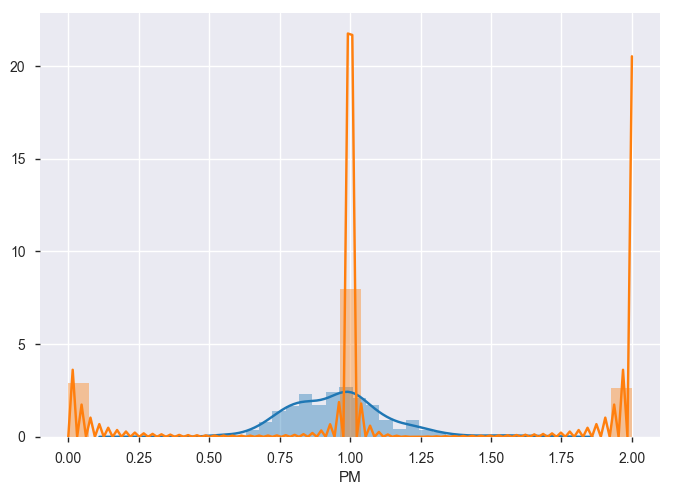

In [18]:
for feature in ['nProductividad', 'PM']:
    sns.distplot(df[feature])

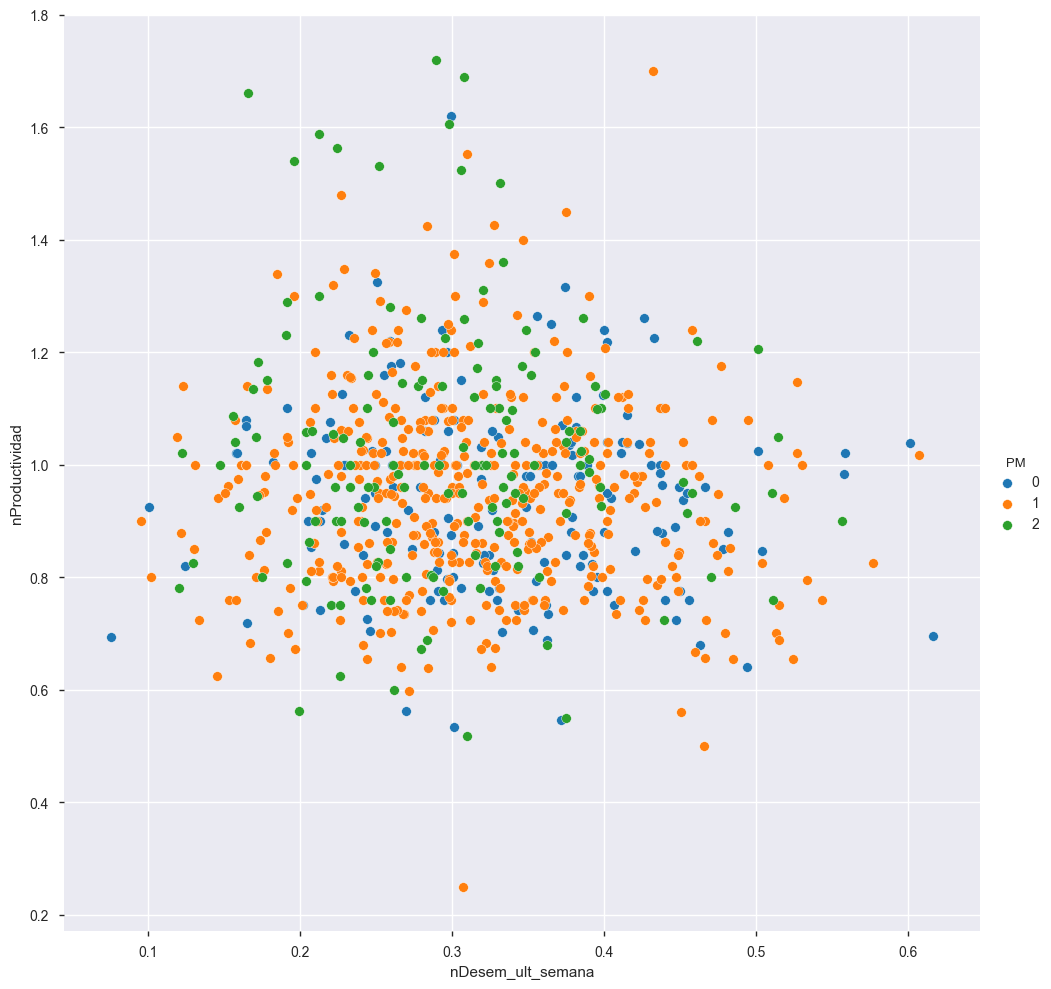

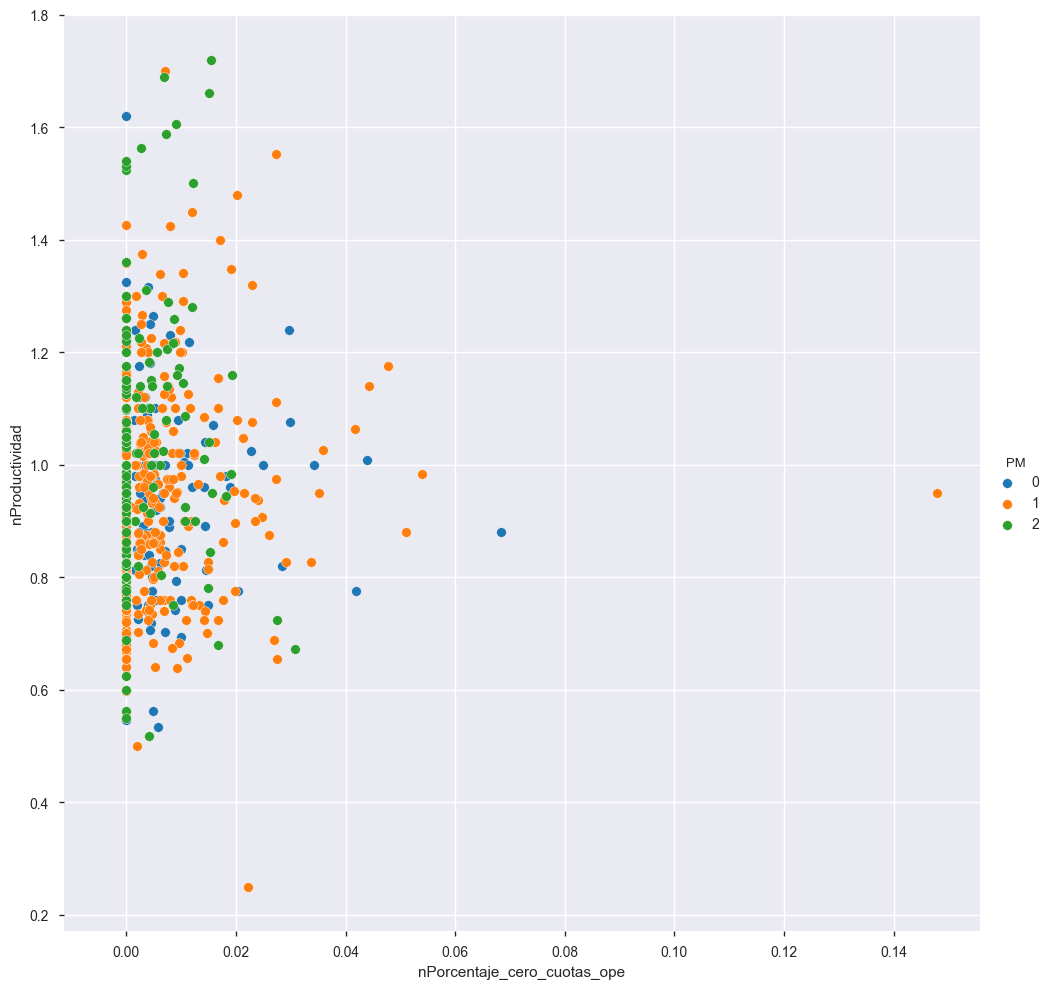

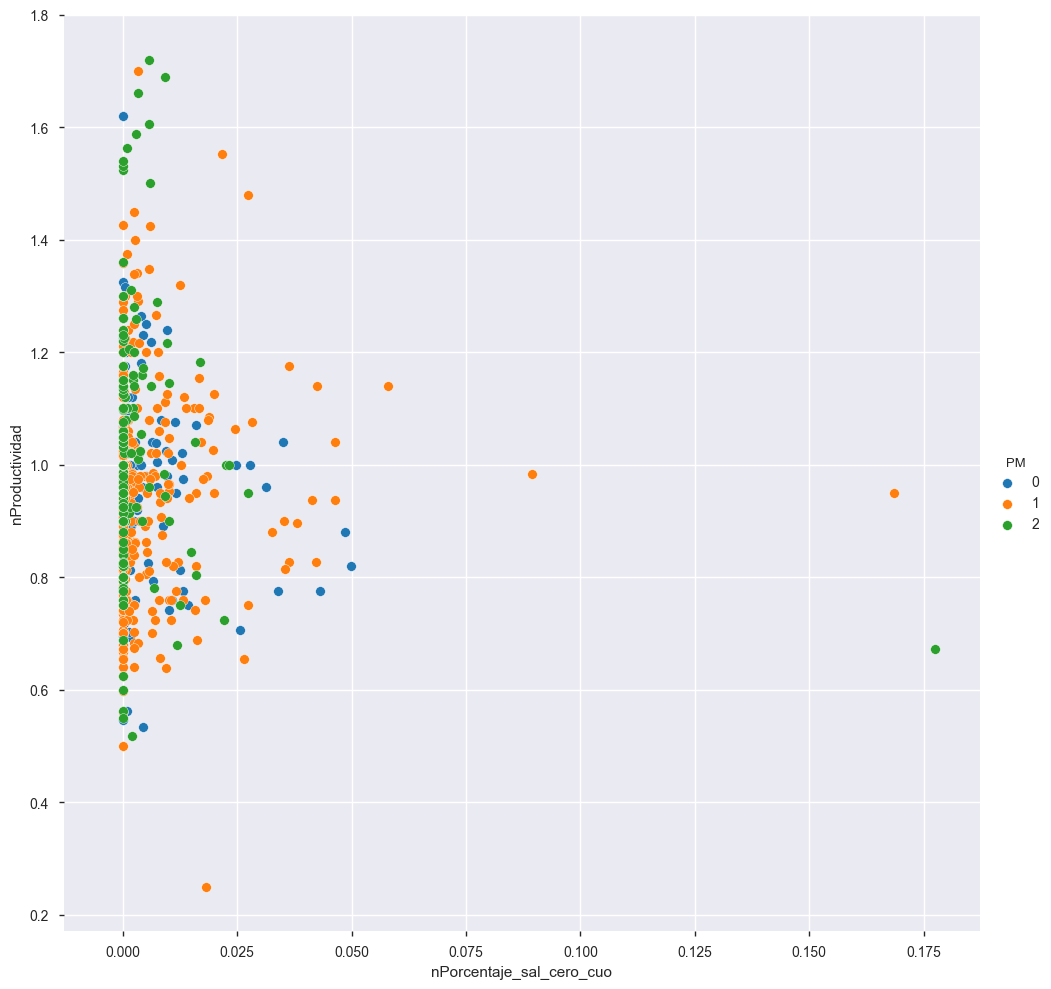

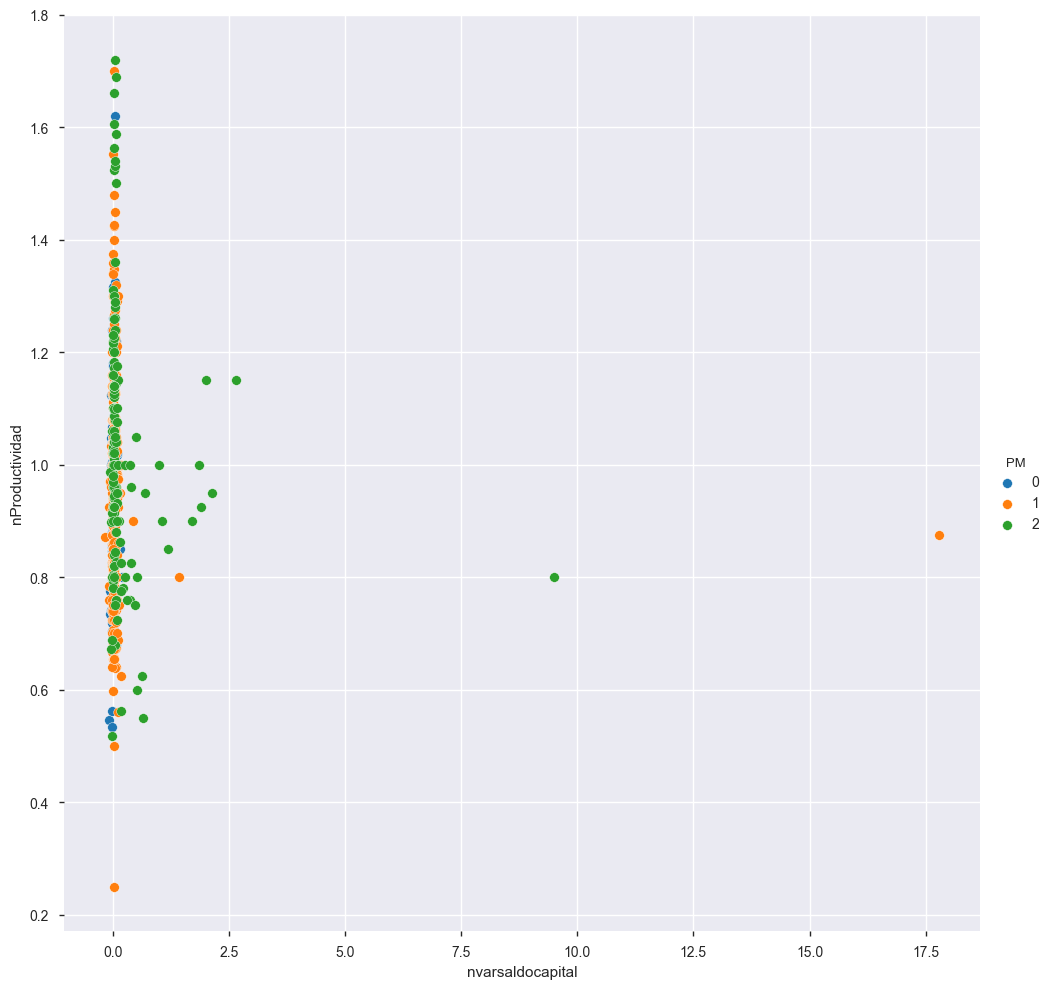

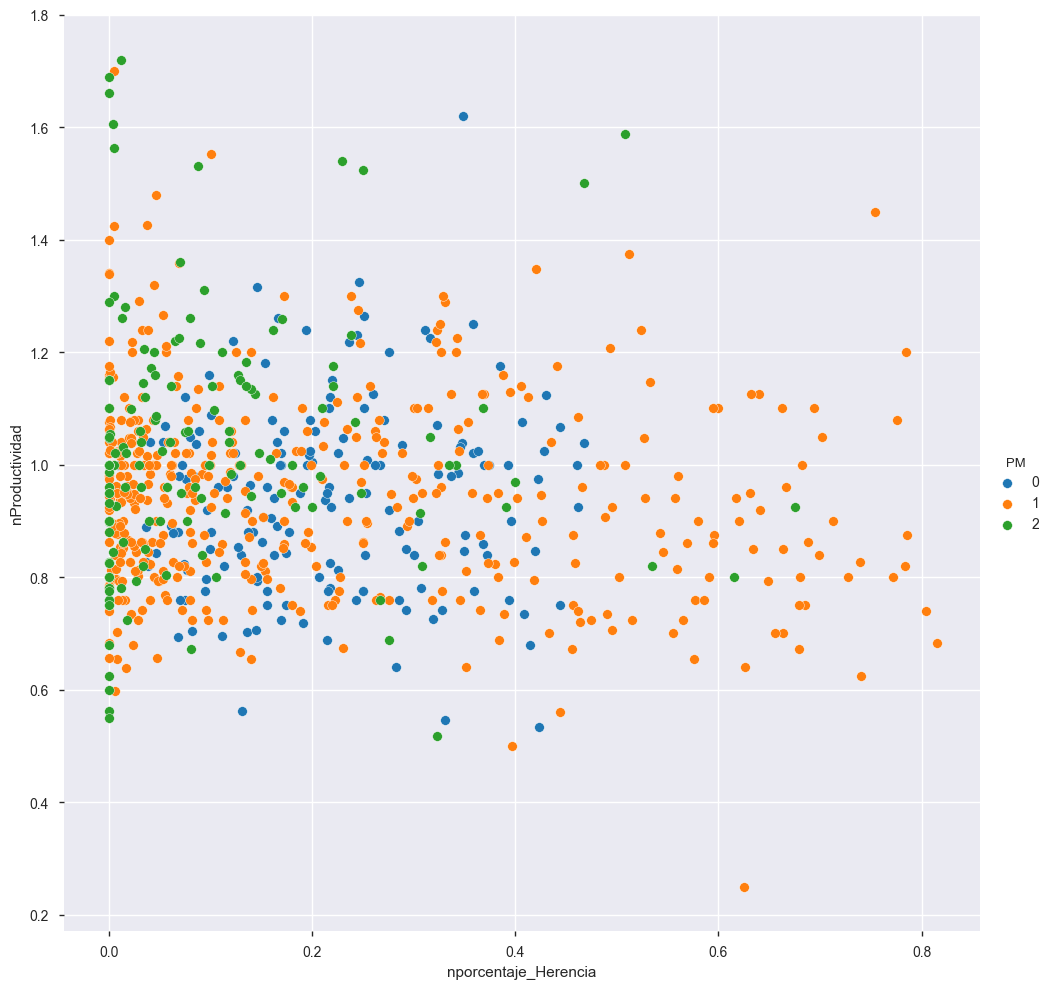

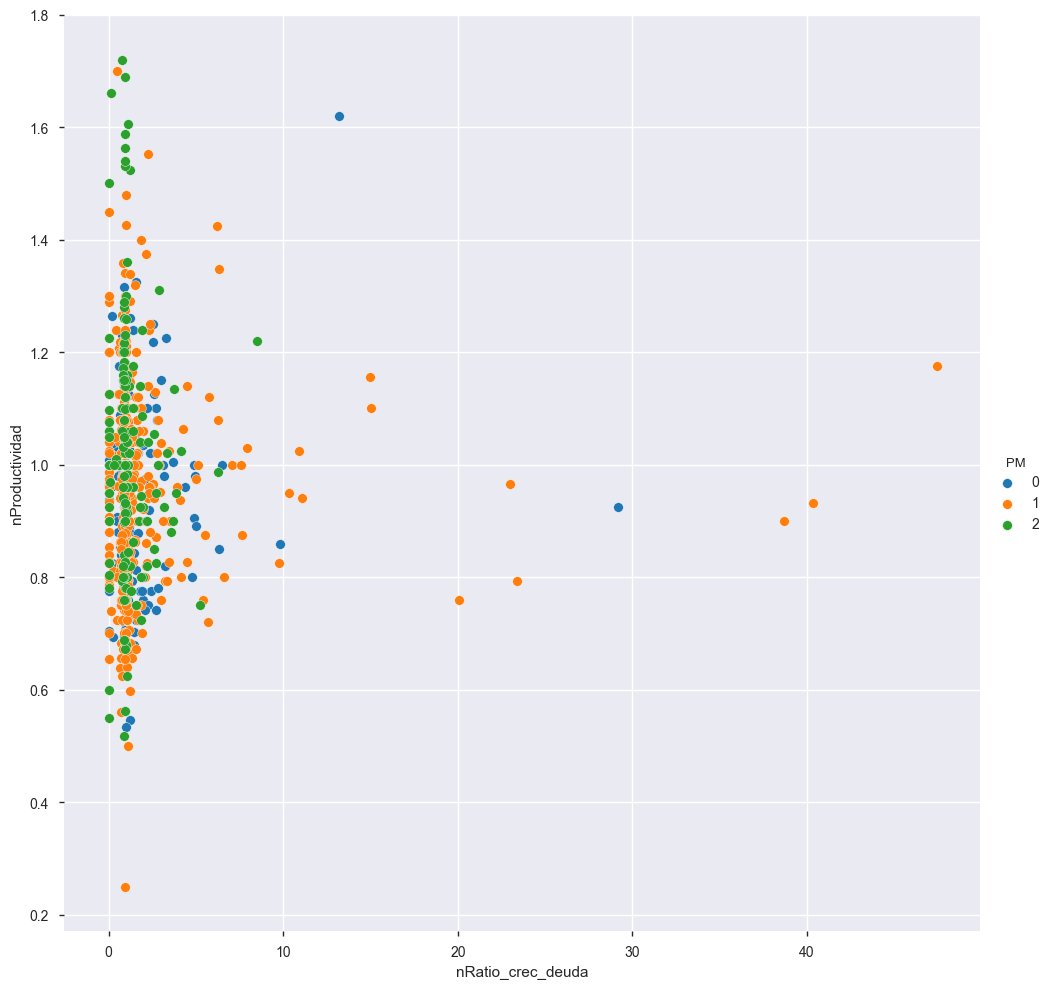

In [19]:
pair_vars = list(df_continuous)
pair_vars.remove('nProductividad')
for feature in pair_vars:
    sns.pairplot(df, x_vars=[feature], y_vars=["nProductividad"], hue="PM", size=10, aspect=1)

# Creating target

In [21]:
df['PM'].value_counts()

1    455
0    164
2    149
Name: PM, dtype: int64

In [22]:
def convert_score(el):
    return 1/(el + 1)

In [23]:
df.loc[:, 'PM'] = df.loc[:, 'PM'].apply(convert_score)

In [24]:
df['PM'].value_counts()

0.500000    455
1.000000    164
0.333333    149
Name: PM, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


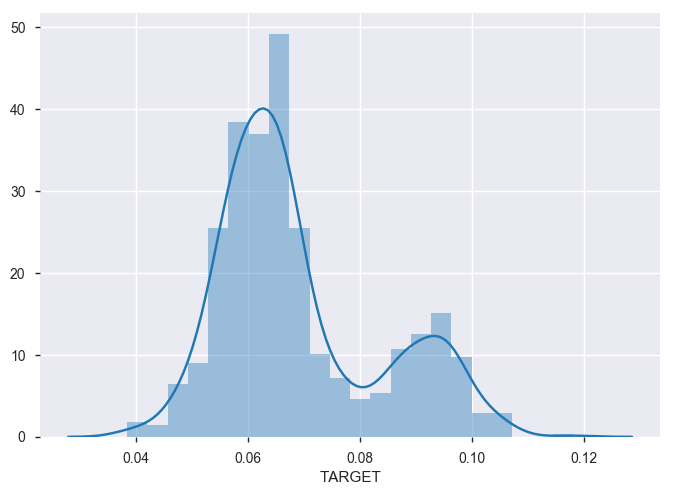

In [25]:
df['N_nProductividad'] = normalize(df['nProductividad'])[0]
df['N_PM'] = normalize(df['PM'])[0]
df['TARGET'] = df['N_nProductividad'] + df['N_PM']
sns.distplot(df['TARGET'])

In [26]:
df = df.drop(['PM', 'N_nProductividad', 'N_PM', 'nProductividad', 'nProbMoraHeredada', 'nProbMoraNoHeredada'], axis=1)
list(df)

['cod_ide',
 'nEntidades_competencia',
 'nDesem_ult_semana',
 'cero_cuotas',
 'nPorcentaje_cero_cuotas_ope',
 'nPorcentaje_sal_cero_cuo',
 'Amonestacion',
 'nAmonestacion_suspension',
 'nvarsaldocapital',
 'herencia',
 'nporcentaje_Herencia',
 'nOperaciones',
 'nRatio_crec_deuda',
 'Edad',
 'Estado_Civil_Sexo',
 'nProductividad_dic',
 'antiguedad',
 'ingresoef',
 'D__ASESOR COMERCIAL FUNCIONARIO',
 'D__ASESOR COMERCIAL JUNIOR 1',
 'D__ASESOR COMERCIAL JUNIOR 2',
 'D__ASESOR COMERCIAL MASTER',
 'D__ASESOR COMERCIAL SENIOR',
 'D__Femenino',
 'D__Masculino',
 'D__Casado',
 'D__Otros',
 'D__Soltero',
 'D__R',
 'D__U',
 'pregunta_1',
 'pregunta_2',
 'pregunta_3',
 'pregunta_4',
 'pregunta_5',
 'pregunta_6',
 'pregunta_7',
 'pregunta_8',
 'pregunta_9',
 'pregunta_10',
 'pregunta_11',
 'pregunta_12',
 'pregunta_13',
 'pregunta_14',
 'pregunta_15',
 'pregunta_16',
 'pregunta_17',
 'pregunta_18',
 'pregunta_19',
 'pregunta_20',
 'pregunta_21',
 'pregunta_22',
 'pregunta_23',
 'pregunta_24',
 'p

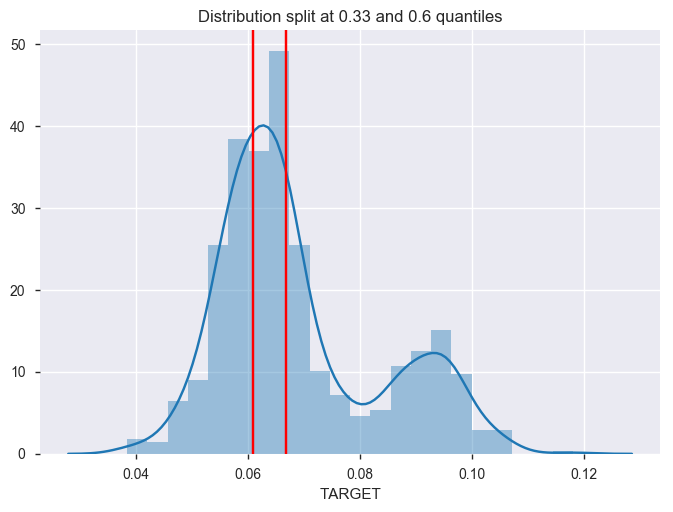

In [27]:
margin1 = 0.33
margin2 = 0.60

sns.distplot(df['TARGET'])
sns.plt.title('Distribution split at {} and {} quantiles'.format(margin1, margin2))
sns.plt.axvline(df['TARGET'].quantile(margin1), color='r')
sns.plt.axvline(df['TARGET'].quantile(margin2), color='r')

plt.show()

In [28]:
df[['cod_ide', 'TARGET']].head()

,cod_ide,TARGET
0,C00000001,0.059532
1,C00000002,0.085980
2,C00000003,0.059688
3,C00000004,0.069756
4,C00000005,0.062603


In [29]:
categories = ['bad', 'normal', 'good']
cuts = [min(df['TARGET']), df['TARGET'].quantile(margin1), df['TARGET'].quantile(margin2), max(df['TARGET'])]
df['TARGET'] = pd.cut(df['TARGET'], cuts, labels=categories, include_lowest=True)

In [30]:
df[['cod_ide', 'TARGET']].head()

,cod_ide,TARGET
0,C00000001,bad
1,C00000002,good
2,C00000003,bad
3,C00000004,good
4,C00000005,normal


In [31]:
df.loc[:, 'TARGET'] = df.loc[:, 'TARGET'].map({
    'bad': 0,
    'normal': 1,
    'good': 2
})
df['TARGET'].value_counts()

2    307
0    258
1    203
Name: TARGET, dtype: int64

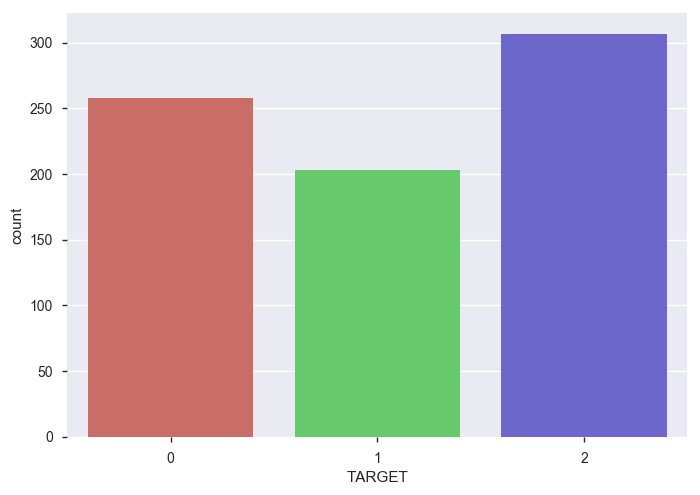

In [32]:
sns.countplot(x="TARGET", data=df, palette='hls')

In [33]:
df = df.drop(['cod_ide', 'Estado_Civil_Sexo'], axis=1)

In [34]:
y = df['TARGET']
X = df.drop('TARGET', axis=1)

In [35]:
X.shape, y.shape

((768, 58), (768,))

# Clustering

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

,nEntidades_competencia,nDesem_ult_semana,cero_cuotas,nPorcentaje_cero_cuotas_ope,nPorcentaje_sal_cero_cuo,Amonestacion,nAmonestacion_suspension,nvarsaldocapital,herencia,nporcentaje_Herencia,...,pregunta_22,pregunta_23,pregunta_24,pregunta_25,pregunta_26,pregunta_27,pregunta_28,pregunta_29,pregunta_30,cluster
0,1,0.256354,1,0.000000,0.000000,0,0,0.013561,1,0.380552,...,0.570065,0.234106,0.962611,0.901311,0.438016,0.909988,0.749946,0.834371,0.497136,-1
1,0,0.406922,1,0.001969,0.000141,0,0,0.042866,1,0.444054,...,0.636884,0.016912,0.786027,0.210207,0.602554,0.612728,0.876735,0.234124,0.274058,-1
2,5,0.321911,1,0.000000,0.000000,0,0,-0.005801,1,0.020612,...,0.805515,0.189345,0.896543,0.876462,0.140416,0.043194,0.699718,0.312835,0.769942,-1
3,3,0.294114,1,0.008791,0.015452,0,0,0.018111,1,0.300313,...,0.669645,0.720994,0.133943,0.257641,0.782434,0.947194,0.658452,0.020218,0.376463,0
4,2,0.315331,0,0.000000,0.000000,0,0,0.004865,1,0.151475,...,0.445472,0.907984,0.903316,0.242125,0.750607,0.054351,0.554076,0.612283,0.849440,1


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

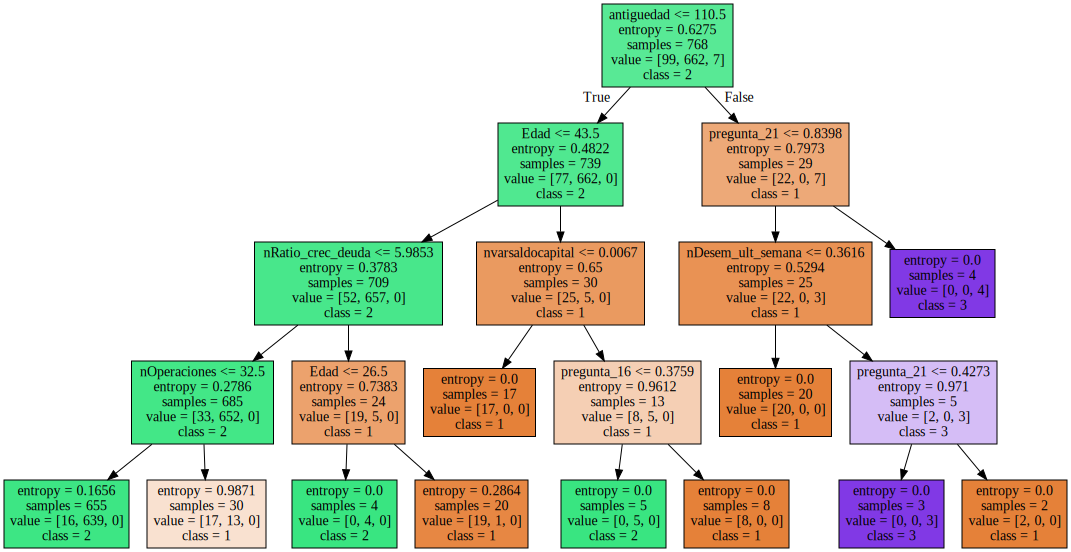

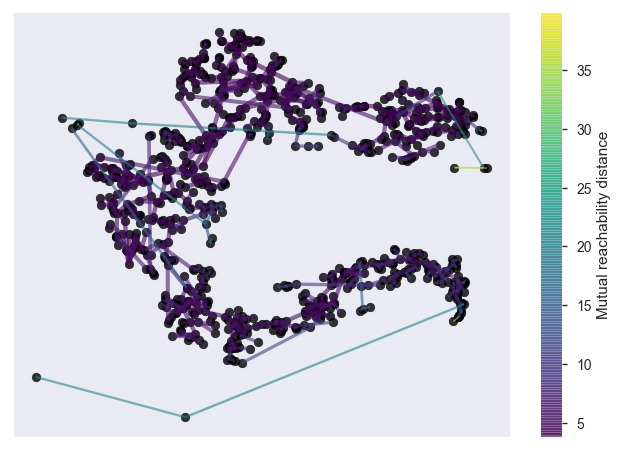

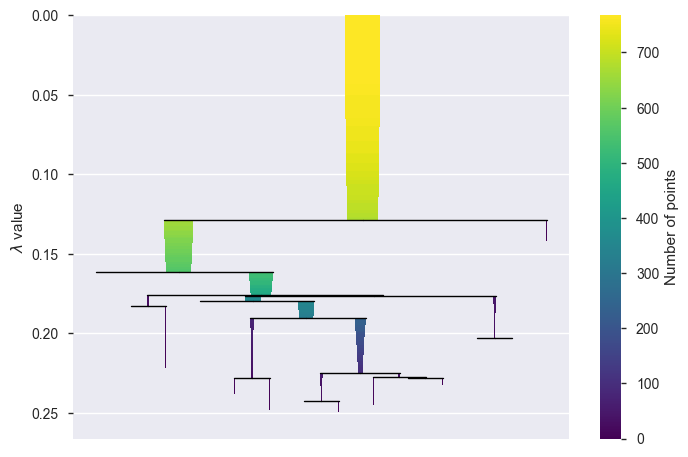

In [36]:
clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
clusterer.fit(X)
plt.figure()
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      edge_linewidth=1)
plt.figure()
clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
X['cluster'] = pd.Series(clusterer.labels_)
X.head()
y_cluster = X['cluster']
X_cluster = X.drop('cluster', axis=1)

cluster_names = list(range(1, len(X['cluster'].value_counts()) + 1))

dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
dtc.fit(X_cluster, y_cluster)

graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

SVG(graph.pipe(format='svg'))

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,nEntidades_competencia,nDesem_ult_semana,cero_cuotas,nPorcentaje_cero_cuotas_ope,nPorcentaje_sal_cero_cuo,Amonestacion,nAmonestacion_suspension,nvarsaldocapital,herencia,nporcentaje_Herencia,...,pregunta_22,pregunta_23,pregunta_24,pregunta_25,pregunta_26,pregunta_27,pregunta_28,pregunta_29,pregunta_30,TARGET
1,0,0.406922,1,0.001969,0.000141,0,0,0.042866,1,0.444054,...,0.636884,0.016912,0.786027,0.210207,0.602554,0.612728,0.876735,0.234124,0.274058,2
3,3,0.294114,1,0.008791,0.015452,0,0,0.018111,1,0.300313,...,0.669645,0.720994,0.133943,0.257641,0.782434,0.947194,0.658452,0.020218,0.376463,2
6,0,0.075777,1,0.010038,0.001483,0,0,-0.000645,1,0.067877,...,0.658786,0.063335,0.965445,0.899193,0.899831,0.736026,0.159117,0.764267,0.752848,2
12,6,0.494248,0,0.000000,0.000000,0,0,0.008872,1,0.283106,...,0.378799,0.296489,0.240698,0.011816,0.812415,0.699946,0.213448,0.192104,0.411602,2
13,0,0.229230,1,0.000000,0.000000,0,0,-0.033884,1,0.368710,...,0.925107,0.009749,0.827324,0.356468,0.019648,0.431121,0.175027,0.228074,0.118559,2


1     0.0
3    -1.0
6    -1.0
12    1.0
13    0.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

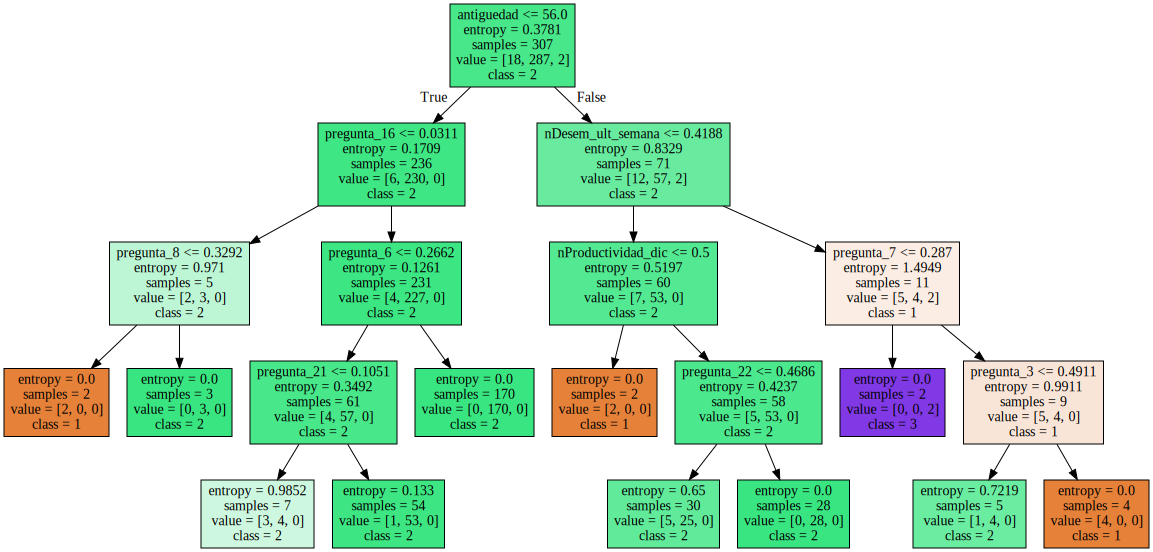

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,nEntidades_competencia,nDesem_ult_semana,cero_cuotas,nPorcentaje_cero_cuotas_ope,nPorcentaje_sal_cero_cuo,Amonestacion,nAmonestacion_suspension,nvarsaldocapital,herencia,nporcentaje_Herencia,...,pregunta_22,pregunta_23,pregunta_24,pregunta_25,pregunta_26,pregunta_27,pregunta_28,pregunta_29,pregunta_30,TARGET
0,1,0.256354,1,0.000000,0.000000,0,0,0.013561,1,0.380552,...,0.570065,0.234106,0.962611,0.901311,0.438016,0.909988,0.749946,0.834371,0.497136,0
2,5,0.321911,1,0.000000,0.000000,0,0,-0.005801,1,0.020612,...,0.805515,0.189345,0.896543,0.876462,0.140416,0.043194,0.699718,0.312835,0.769942,0
8,0,0.362352,1,0.016685,0.011728,1,1,0.031143,0,0.000000,...,0.059929,0.654044,0.781196,0.473870,0.276165,0.027290,0.196625,0.916725,0.814199,0
9,2,0.221844,0,0.000000,0.000000,0,0,0.008442,1,0.049933,...,0.365343,0.469267,0.401152,0.433707,0.460116,0.141991,0.864341,0.963025,0.495362,0
11,0,0.397763,1,0.003868,0.000118,0,0,0.008172,0,0.000000,...,0.912715,0.689475,0.696381,0.937935,0.766764,0.012020,0.314553,0.095520,0.235121,0


0    -1.0
2    -1.0
8     1.0
9     1.0
11    1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

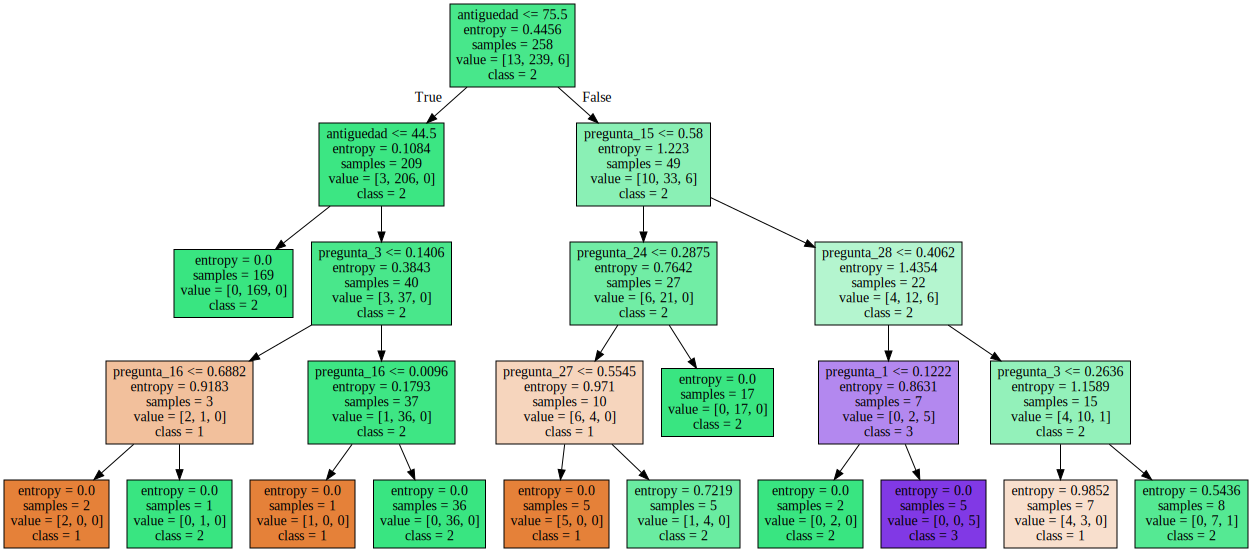

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,nEntidades_competencia,nDesem_ult_semana,cero_cuotas,nPorcentaje_cero_cuotas_ope,nPorcentaje_sal_cero_cuo,Amonestacion,nAmonestacion_suspension,nvarsaldocapital,herencia,nporcentaje_Herencia,...,pregunta_22,pregunta_23,pregunta_24,pregunta_25,pregunta_26,pregunta_27,pregunta_28,pregunta_29,pregunta_30,TARGET
4,2,0.315331,0,0.000000,0.00000,0,0,0.004865,1,0.151475,...,0.445472,0.907984,0.903316,0.242125,0.750607,0.054351,0.554076,0.612283,0.849440,1
5,5,0.351645,1,0.004474,0.00126,0,0,0.019909,1,0.402010,...,0.290068,0.085717,0.288015,0.906774,0.494239,0.850435,0.714784,0.661038,0.508912,1
7,0,0.461129,0,0.000000,0.00000,0,0,-0.009965,1,0.065337,...,0.665051,0.223808,0.705550,0.578905,0.665882,0.387134,0.328389,0.496447,0.848119,1
10,1,0.284317,0,0.000000,0.00000,0,0,-0.009481,1,0.103537,...,0.892017,0.835857,0.423259,0.981828,0.301262,0.538293,0.511511,0.073464,0.793432,1
15,4,0.263154,1,0.000000,0.00000,0,0,0.022777,1,0.253971,...,0.522969,0.771341,0.423175,0.542268,0.991654,0.236079,0.203580,0.222653,0.720546,1


4     1.0
5    -1.0
7    -1.0
10   -1.0
15   -1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

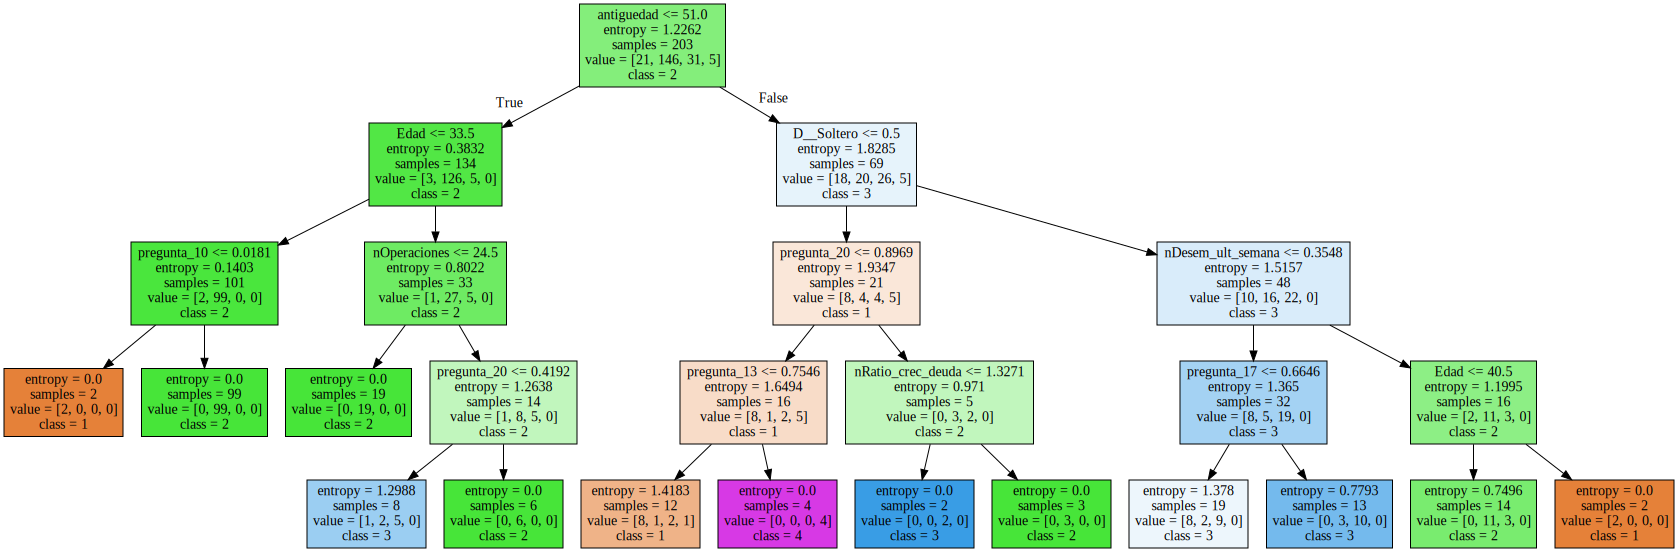

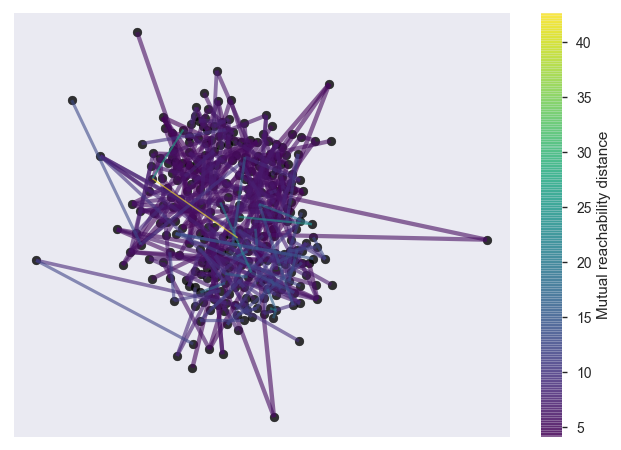

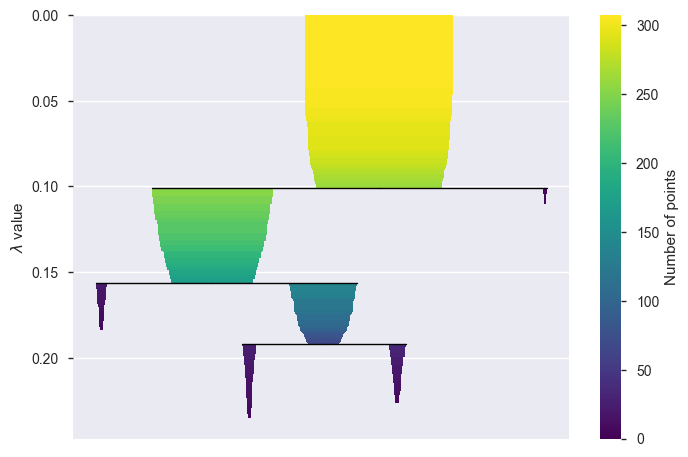

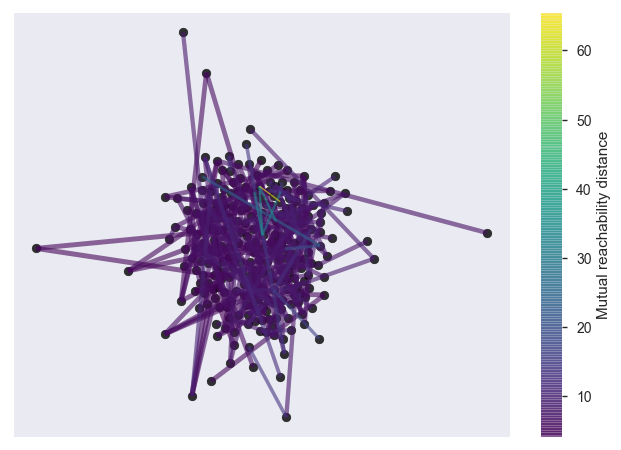

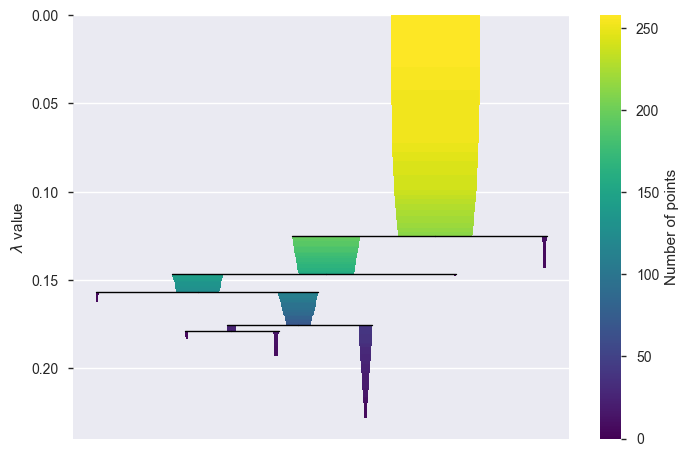

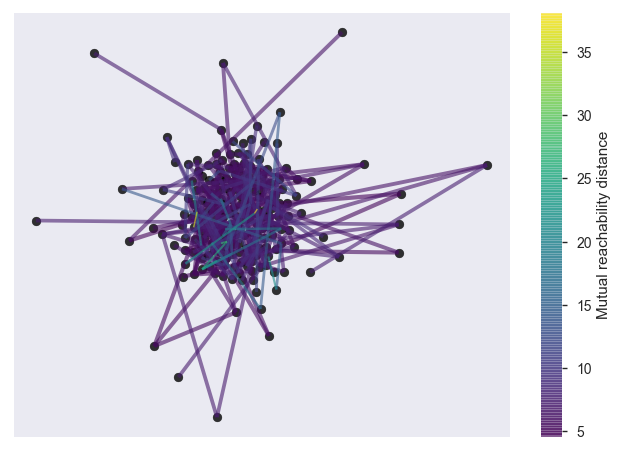

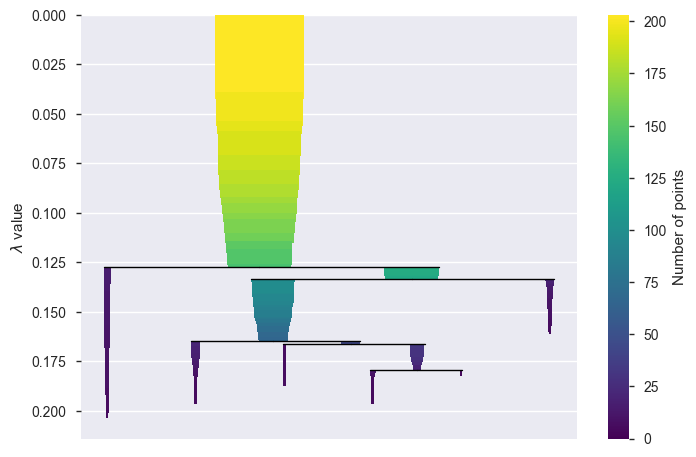

In [37]:
for target_class in list(y.value_counts().index):
    X_target = df.loc[df['TARGET'] == target_class]
    clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
    clusterer.fit(X_target)
    plt.figure()
    clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                          edge_alpha=0.6,
                                          edge_linewidth=1)
    plt.figure()
    clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())
    palette = sns.color_palette()
    cluster_colors = [sns.desaturate(palette[col], sat)
                      if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                      zip(clusterer.labels_, clusterer.probabilities_)]
    X_target['cluster'] = pd.Series(clusterer.labels_)
    y_cluster = X_target['cluster']
    X_cluster = X_target.drop('cluster', axis=1)
    
    X_cluster.head()
    y_cluster.head()
    
    cluster_names = list(range(1, len(X_target['cluster'].value_counts()) + 1))

    dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
    dtc.fit(X_cluster.fillna(0), y_cluster.fillna(0))

    graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

    SVG(graph.pipe(format='svg'))

In [38]:
X.shape, y.shape

((768, 59), (768,))

In [40]:
X.to_csv('X.csv', index=False)
y.to_csv('y.csv', index=False)

# Cross-validation

In [41]:
eval_size = 0.1
kf = StratifiedKFold(df['TARGET'], round(1./eval_size))
train_ix, valid_ix = next(iter(kf))

In [42]:
X_train, y_train = X.iloc[train_ix], y.iloc[train_ix]
X_valid, y_valid = X.iloc[valid_ix], y.iloc[valid_ix]
X_train.shape, y_train.shape
X_valid.shape, y_valid.shape

((690, 59), (690,))

((78, 59), (78,))

# Models

In [43]:
model_results = {
    'lightgbm': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'random_forest': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'extra_trees': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    }
}

## LightGBM

In [44]:
d_train = lgb.Dataset(X_train, y_train)
d_valid = lgb.Dataset(X_valid, y_valid, reference=d_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05], 'num_leaves': [8, 10, 20, 30, 40, 50], 'boosting_type': ['gbdt'], 'objective': ['multiclass'], 'metric': ['multi_logloss'], 'num_class': [3], 'seed': [777], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1], 'subsample': [0.6, 0.7, 0.8, 0.9, 1], 'reg_alpha': [0, 0.1, 0.5, 1], 'reg_lambda': [0, 0.01, 0.05, 0.1, 1, 2, 5, 6, 7, 9, 10], 'is_unbalance': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9,
 'is_unbalance': True,
 'learning_rate': 0.03,
 'metric': 'multi_logloss',
 'num_class': 3,
 'num_leaves': 8,
 'objective': 'multiclass',
 'reg_alpha': 0.5,
 'reg_lambda': 2,
 'seed': 777,
 'subsample': 0.8}

Recall: 0.7096774193548387
Precision: 0.5116279069767442
Accuracy: 0.5256410256410257


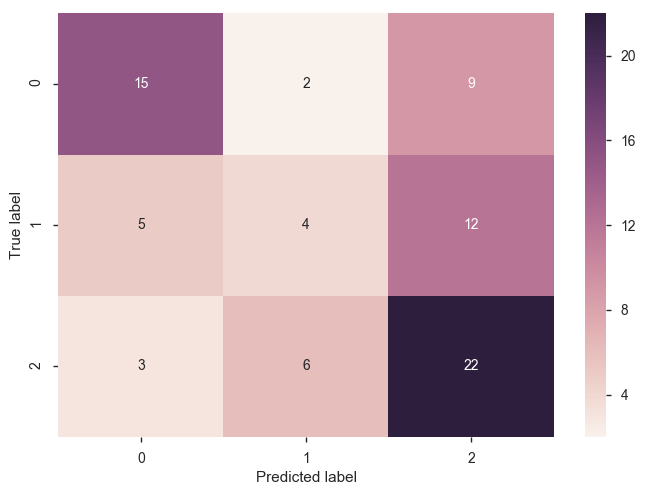

In [45]:
estimator = lgb.LGBMClassifier()
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03,0.04, 0.05],
    'num_leaves': [8, 10, 20, 30, 40, 50],
    'boosting_type' : ['gbdt'],
    'objective' : ['multiclass'],
    'metric': ['multi_logloss'],
    'num_class': [3],
    'seed' : [777],
    'colsample_bytree' : [0.6, 0.7,0.8,0.9,1],
    'subsample' : [0.6, 0.7,0.8,0.9,1],
    'reg_alpha' : [0,0.1,0.5,1],
    'reg_lambda' : [0,0.01, 0.05, 0.1, 1,2,5,6,7,9,10],
    'is_unbalance' : [True,False],
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

[1]	valid_0's multi_logloss: 1.09211
[2]	valid_0's multi_logloss: 1.08596
[3]	valid_0's multi_logloss: 1.0804
[4]	valid_0's multi_logloss: 1.07543
[5]	valid_0's multi_logloss: 1.07053
[6]	valid_0's multi_logloss: 1.06628
[7]	valid_0's multi_logloss: 1.06187
[8]	valid_0's multi_logloss: 1.05709
[9]	valid_0's multi_logloss: 1.05301
[10]	valid_0's multi_logloss: 1.04887
[11]	valid_0's multi_logloss: 1.04525
[12]	valid_0's multi_logloss: 1.04129
[13]	valid_0's multi_logloss: 1.03722
[14]	valid_0's multi_logloss: 1.0339
[15]	valid_0's multi_logloss: 1.02972
[16]	valid_0's multi_logloss: 1.02669
[17]	valid_0's multi_logloss: 1.02458
[18]	valid_0's multi_logloss: 1.02146
[19]	valid_0's multi_logloss: 1.0182
[20]	valid_0's multi_logloss: 1.01558
[21]	valid_0's multi_logloss: 1.01514
[22]	valid_0's multi_logloss: 1.01386
[23]	valid_0's multi_logloss: 1.0105
[24]	valid_0's multi_logloss: 1.00783
[25]	valid_0's multi_logloss: 1.00541
[26]	valid_0's multi_logloss: 1.00227
[27]	valid_0's multi_logl

Recall: 0.6774193548387096
Precision: 0.525
Accuracy: 0.5512820512820513


Feature importance based on entropy:
Feature ranking with recursive feature elimination:


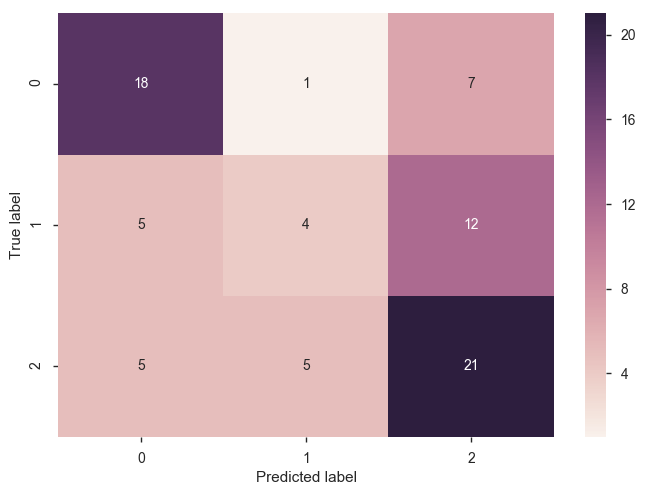

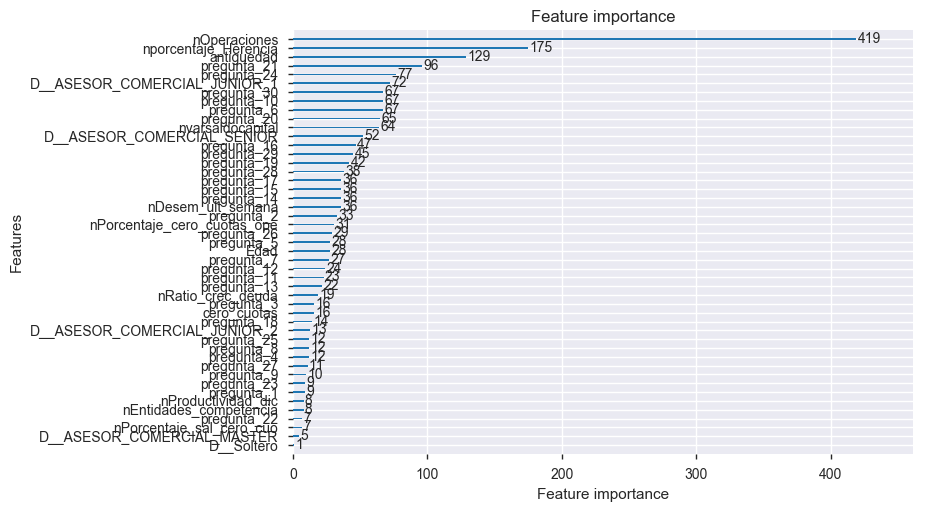

In [46]:
model = lgb.train(clf.best_params_, d_train, 100, valid_sets=d_valid)

y_pred = model.predict(X_valid)

y_pred_trunc = list()
for row in y_pred:
    y_pred_trunc.append(list(row).index(max(row)))
y_pred_trunc = pd.Series(y_pred_trunc)

cm = confusion_matrix(y_valid, y_pred_trunc)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['lightgbm']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['lightgbm']['precision'] = precision

accuracy = accuracy_score(y_pred_trunc, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['lightgbm']['accuracy'] = accuracy

lgb.plot_importance(model)

print('Feature importance based on entropy:')
d = dict(zip(model.feature_name(), model.feature_importance()))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['lightgbm']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['lightgbm']['fe_rfe'] = fe_rfe

## Random Forest

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'max_depth': [5, 8, 15, 25, 30, None], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'max_depth': 8,
 'min_samples_leaf': 5,
 'min_samples_split': 15,
 'n_estimators': 120}

Recall: 0.7096774193548387
Precision: 0.4782608695652174
Accuracy: 0.47435897435897434


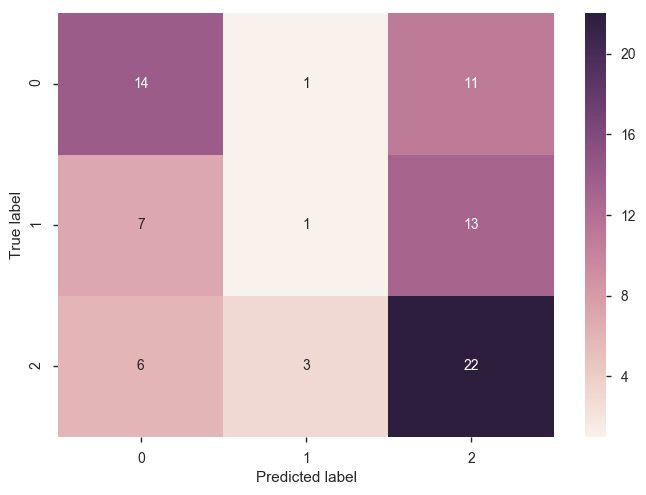

In [47]:
estimator = RandomForestClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'max_depth': [5, 8, 15, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            n_estimators=120, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False)

Recall: 0.7096774193548387
Precision: 0.4782608695652174
Accuracy: 0.47435897435897434
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


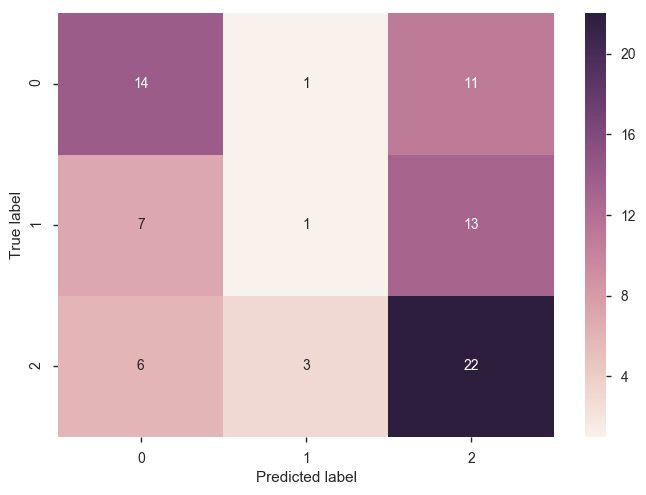

In [48]:
model = RandomForestClassifier(
    max_depth=clf.best_params_['max_depth'],
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['random_forest']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['random_forest']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['random_forest']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['random_forest']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['random_forest']['fe_rfe'] = fe_rfe

# Extra Trees

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}

Recall: 0.7096774193548387
Precision: 0.5
Accuracy: 0.48717948717948717


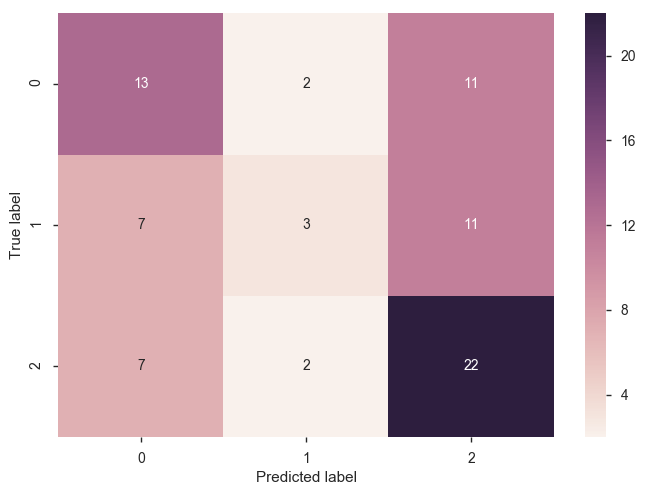

In [49]:
estimator = ExtraTreesClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False)

Recall: 0.7096774193548387
Precision: 0.5
Accuracy: 0.48717948717948717
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


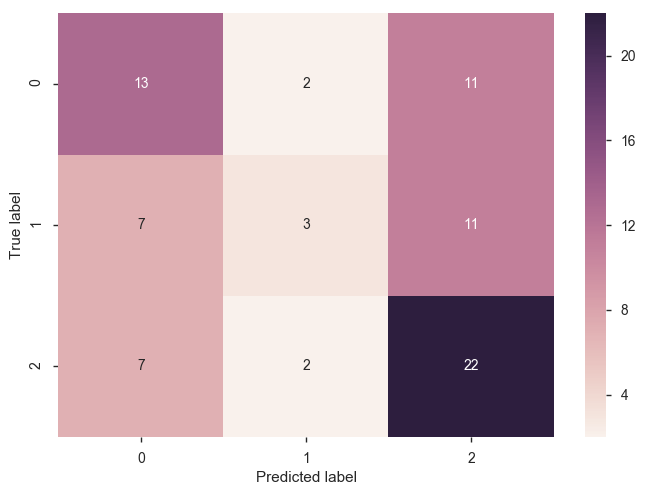

In [50]:
model = ExtraTreesClassifier(
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['extra_trees']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['extra_trees']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['extra_trees']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['extra_trees']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['extra_trees']['fe_rfe'] = fe_rfe

### Garbage collection

In [51]:
del DecisionTreeClassifier, ExtraTreesClassifier, RandomForestClassifier, RandomizedSearchCV, RFE, SVG, Source, StratifiedKFold
del X, y, X_cluster, X_target, X_train, X_valid, accuracy, accuracy_score, categories, clf, cluster_colors, clusterer, cm
del confusion_matrix, convert_score, cuts, d, d_train, d_valid, df_categorical, df_continuous, df_discrete, df_numeric, dtc
del dtypes, estimator, eval_size, export_graphviz, f1_score, fe_entropy, fe_rfe, feature, g, graph, hdbscan
del i, kf, lgb, make_correlation_graphic, margin1, margin2, model, num_questions, pair_vars, pandas_profiling, param_grid
del precision, precision_score, recall, recall_score, row, selector, target_class, train_ix, valid_ix, y_cluster, y_pred
del y_pred_trunc, y_train, y_valid
collect()

632

# Results

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


,entropy,rfe,N_entropy,N_rfe,score
nOperaciones,0.059698,1,0.421581,0.004189,0.425770
cero_cuotas,0.024358,35,0.172013,0.146619,0.318632
herencia,0.013820,52,0.097598,0.217835,0.315432
D__Masculino,0.013875,49,0.097984,0.205267,0.303251
nProductividad_dic,0.018272,41,0.129039,0.171754,0.300793
D__ASESOR COMERCIAL JUNIOR 2,0.014150,47,0.099928,0.196889,0.296817
D__ASESOR COMERCIAL JUNIOR 1,0.013508,48,0.095392,0.201078,0.296470
D__U,0.011179,51,0.078944,0.213645,0.292590
D__ASESOR COMERCIAL SENIOR,0.016947,39,0.119678,0.163376,0.283054
ingresoef,0.013842,43,0.097753,0.180132,0.277886


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),
 <a list of 59 Text xticklabel objects>)

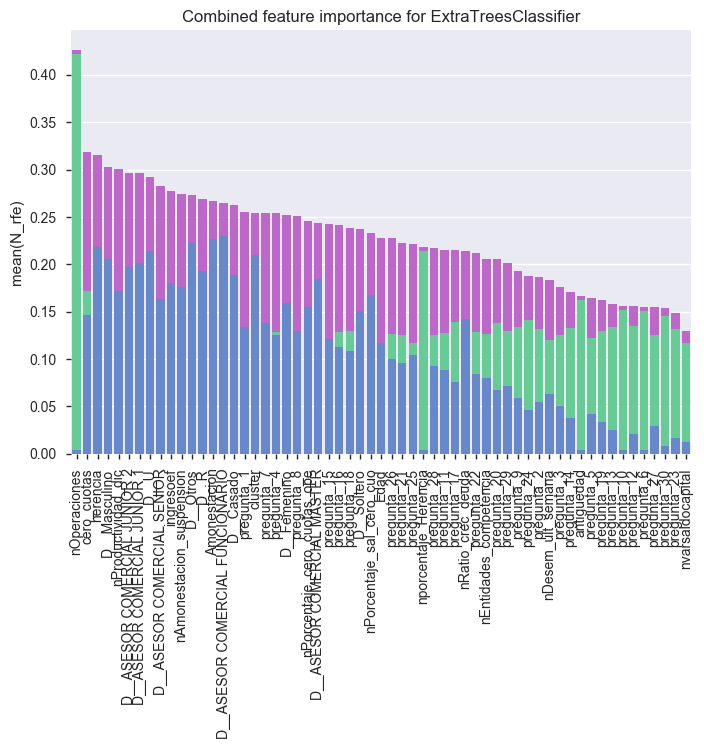

In [52]:
df1 = pd.DataFrame(model_results['extra_trees']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['extra_trees']['fe_rfe']).set_index(0)
results_extra_trees = pd.concat([df1, df2], axis=1)

results_extra_trees.columns = ['entropy', 'rfe']
results_extra_trees['N_entropy'] = normalize(results_extra_trees['entropy'])[0]
results_extra_trees['N_rfe'] = normalize(results_extra_trees['rfe'])[0]

results_extra_trees['score'] = results_extra_trees['N_entropy'] + results_extra_trees['N_rfe']

results_extra_trees = results_extra_trees.sort_values('score', ascending=False)

results_extra_trees

plt.title('Combined feature importance for ExtraTreesClassifier')
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


,entropy,rfe,N_entropy,N_rfe,score
nOperaciones,0.112442,1,0.589850,0.004189,0.594040
nporcentaje_Herencia,0.067580,1,0.354510,0.004189,0.358700
antiguedad,0.063019,4,0.330585,0.016757,0.347341
nPorcentaje_cero_cuotas_ope,0.018270,36,0.095842,0.150809,0.246651
pregunta_4,0.019616,34,0.102899,0.142430,0.245330
herencia,0.002356,54,0.012359,0.226213,0.238572
D__R,0.001176,55,0.006168,0.230402,0.236570
nProductividad_dic,0.009775,43,0.051279,0.180132,0.231411
D__U,0.000927,53,0.004863,0.222024,0.226887
pregunta_25,0.019490,29,0.102242,0.121485,0.223727


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),
 <a list of 59 Text xticklabel objects>)

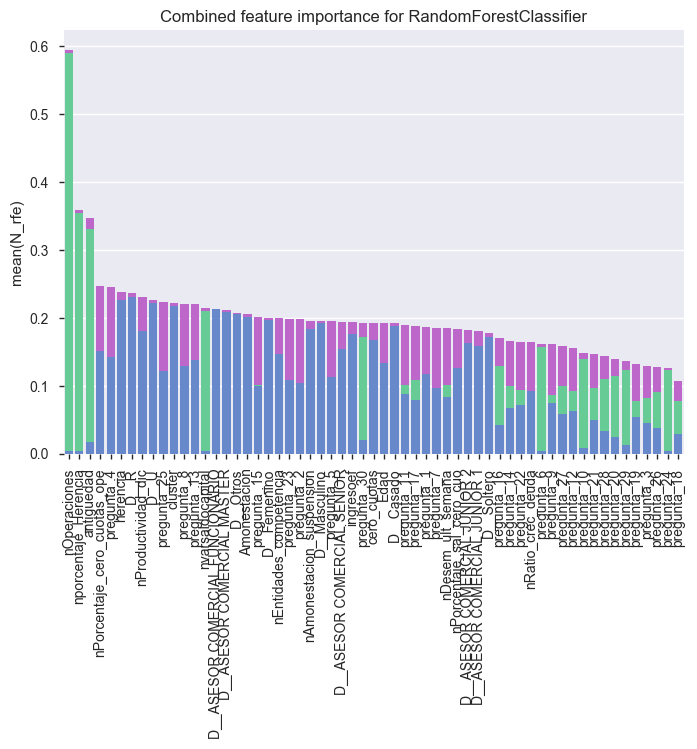

In [53]:
df1 = pd.DataFrame(model_results['random_forest']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['random_forest']['fe_rfe']).set_index(0)
results_random_forest = pd.concat([df1, df2], axis=1)

results_random_forest.columns = ['entropy', 'rfe']
results_random_forest['N_entropy'] = normalize(results_random_forest['entropy'])[0]
results_random_forest['N_rfe'] = normalize(results_random_forest['rfe'])[0]

results_random_forest['score'] = results_random_forest['N_entropy'] + results_random_forest['N_rfe']

results_random_forest = results_random_forest.sort_values('score', ascending=False)

results_random_forest

plt.title('Combined feature importance for RandomForestClassifier')
sns.barplot(x=results_random_forest.index, y=results_random_forest['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_random_forest.index, y=results_random_forest['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_random_forest.index, y=results_random_forest['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

,nOperaciones,nporcentaje_Herencia,antiguedad,pregunta_21,pregunta_24,D__ASESOR_COMERCIAL_JUNIOR_1,pregunta_6,pregunta_10,pregunta_30,pregunta_20,...,herencia,ingresoef,D__ASESOR_COMERCIAL_FUNCIONARIO,D__Femenino,D__Masculino,D__Casado,D__Otros,D__R,D__U,cluster
1,419,175,129,96,77,72,67,67,67,65,...,0,0,0,0,0,0,0,0,0,0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


,entropy,rfe,N_entropy,N_rfe,score
nOperaciones,419,1,0.778929,0.004189,0.783118
nporcentaje_Herencia,175,1,0.325328,0.004189,0.329517
D__ASESOR COMERCIAL SENIOR,52,38,0.096669,0.159187,0.255856
pregunta_20,65,32,0.120836,0.134052,0.254888
antiguedad,129,1,0.239813,0.004189,0.244003
D__U,0,55,0.000000,0.230402,0.230402
D__Otros,0,54,0.000000,0.226213,0.226213
pregunta_21,96,11,0.178466,0.046080,0.224546
Amonestacion,0,53,0.000000,0.222024,0.222024
nPorcentaje_cero_cuotas_ope,31,39,0.057630,0.163376,0.221006


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),
 <a list of 59 Text xticklabel objects>)

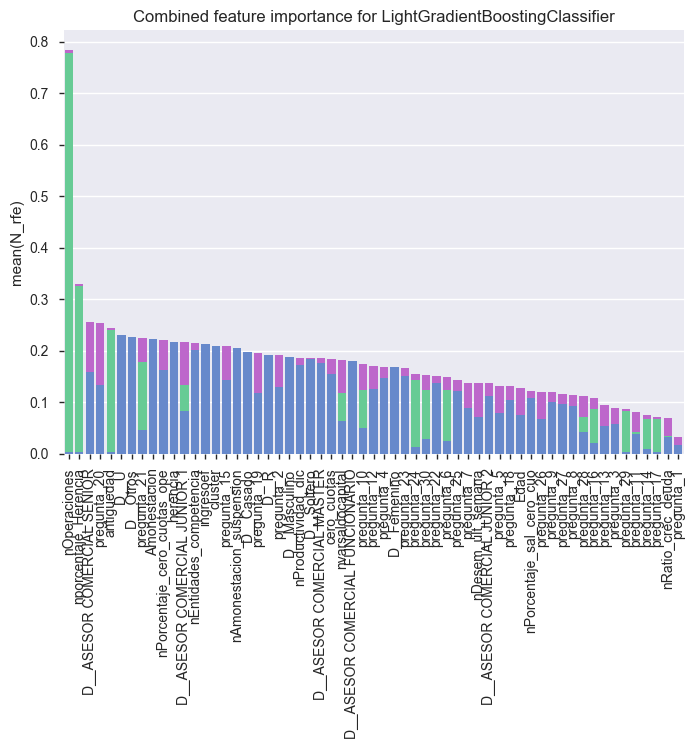

In [54]:
df1 = pd.DataFrame(model_results['lightgbm']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['lightgbm']['fe_rfe']).set_index(0)

df1 = df1.T
df1

for feature in [col for col in df1.columns if col.startswith('D_')]:
    df1 = df1.rename(columns={
        feature: feature.replace('_', ' ').replace('D  ', 'D__')
    })

df1 = df1.T
    
results_lightgbm = pd.concat([df1, df2], axis=1)

results_lightgbm.columns = ['entropy', 'rfe']
results_lightgbm['N_entropy'] = normalize(results_lightgbm['entropy'])[0]
results_lightgbm['N_rfe'] = normalize(results_lightgbm['rfe'])[0]

results_lightgbm['score'] = results_lightgbm['N_entropy'] + results_lightgbm['N_rfe']

results_lightgbm = results_lightgbm.sort_values('score', ascending=False)

results_lightgbm

plt.title('Combined feature importance for LightGradientBoostingClassifier')
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

,extra_trees,random_forest,lightgbm,score
nOperaciones,0.425770,0.594040,0.783118,1.802928
nporcentaje_Herencia,0.218427,0.358700,0.329517,0.906644
herencia,0.315432,0.238572,0.217835,0.771838
antiguedad,0.166933,0.347341,0.244003,0.758277
D__U,0.292590,0.226887,0.230402,0.749878
D__ASESOR COMERCIAL SENIOR,0.283054,0.194590,0.255856,0.733499
nProductividad_dic,0.300793,0.231411,0.186626,0.718831
nPorcentaje_cero_cuotas_ope,0.246200,0.246651,0.221006,0.713857
D__Otros,0.273232,0.207580,0.226213,0.707025
D__R,0.269207,0.236570,0.192700,0.698476


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),
 <a list of 59 Text xticklabel objects>)

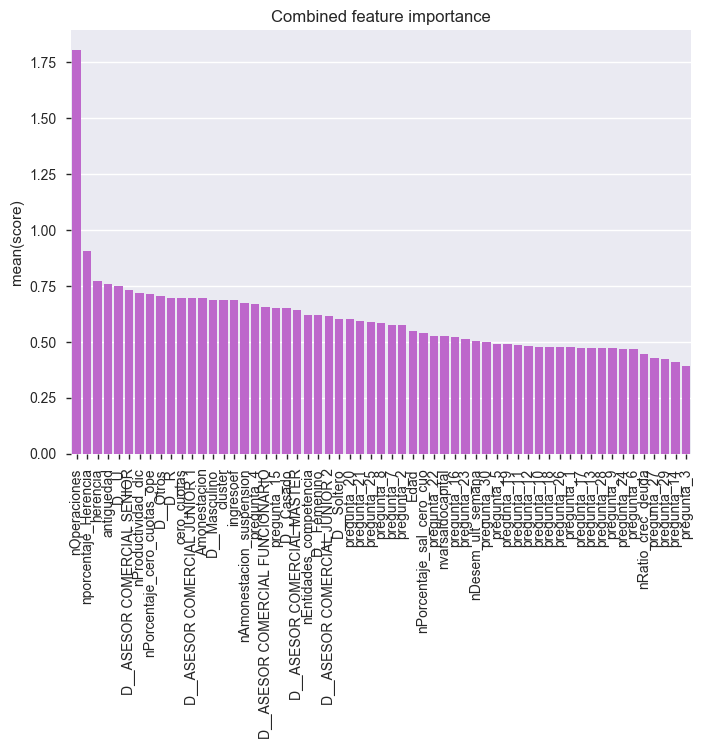

In [55]:
df_results = pd.concat([results_extra_trees['score'], results_random_forest['score'], results_lightgbm['score']], axis=1)
df_results.columns = ['extra_trees', 'random_forest', 'lightgbm']
df_results['score'] = df_results['extra_trees'] + df_results['random_forest'] + df_results['lightgbm']

df_results = df_results.sort_values('score', ascending=False)

df_results

plt.title('Combined feature importance')
sns.barplot(x=df_results.index, y=df_results['score'], color=sns.color_palette("hls", 5)[4])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),
 <a list of 59 Text xticklabel objects>)

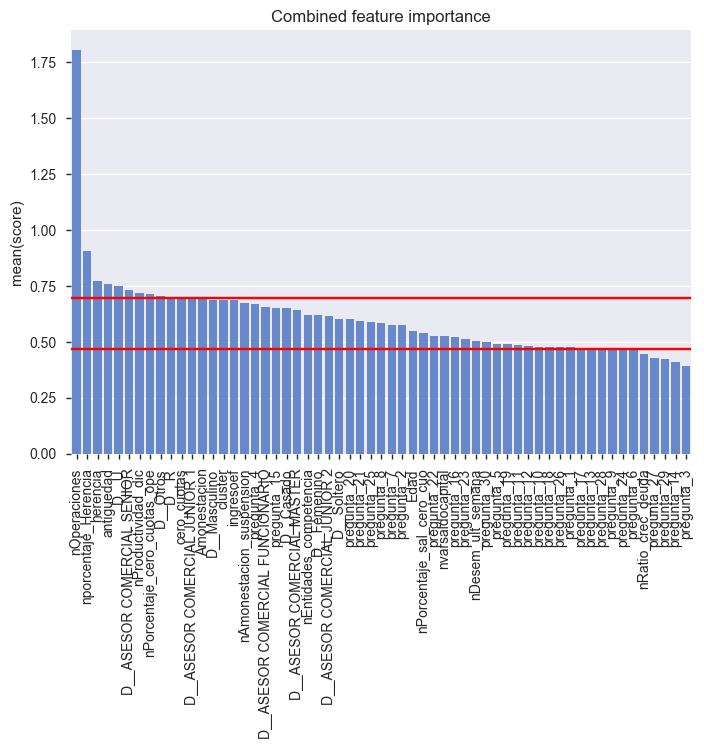

In [56]:
margin1 = 0.1
margin2 = 0.8

plt.title('Combined feature importance')
sns.barplot(x=df_results.index, y=df_results['score'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)
sns.plt.axhline(df_results['score'].quantile(margin1), color='r')
sns.plt.axhline(df_results['score'].quantile(margin2), color='r')

In [57]:
categories = ['bad', 'uncertain', 'good']
cuts = [
    min(df_results['score']), 
    df_results['score'].quantile(margin1), 
    df_results['score'].quantile(margin2), 
    max(df_results['score'])
]
df_results['score'] = pd.cut(df_results['score'], cuts, labels=categories, include_lowest=True)
df_results['score']

nOperaciones                            good
nporcentaje_Herencia                    good
herencia                                good
antiguedad                              good
D__U                                    good
D__ASESOR COMERCIAL SENIOR              good
nProductividad_dic                      good
nPorcentaje_cero_cuotas_ope             good
D__Otros                                good
D__R                                    good
cero_cuotas                             good
D__ASESOR COMERCIAL JUNIOR 1            good
Amonestacion                       uncertain
D__Masculino                       uncertain
cluster                            uncertain
ingresoef                          uncertain
nAmonestacion_suspension           uncertain
pregunta_4                         uncertain
D__ASESOR COMERCIAL FUNCIONARIO    uncertain
pregunta_15                        uncertain
D__Casado                          uncertain
D__ASESOR COMERCIAL MASTER         uncertain
nEntidades

In [58]:
uncertain_features = list(df_results.loc[df_results['score'] == 'uncertain'].T.columns)

In [59]:
with open('uncertain_features.txt', 'wb') as fp:
    pickle.dump(uncertain_features, fp)

# Recomendaciones

In [60]:
# graficos bonitos para exploracion
# titulos a los graficos

# ver outliers: altos (recomendar chequear pero son buenos), bajos (recomendar quitar)
# centrales: volver a correr modelo pero solo con esos y luego igual, altos y bajos
# correlaciones: revisar grupos correlacionados, especialmente si alguno se correlaciona con el target
# unir con uncertain_pass
# añadir lime

# una vez terminado, separar hk1 (demo y preguntas) y hk2 (operaciones, desembolsos, etc)